In [32]:
from datasets import get_dataset_config_names
from datasets import load_dataset
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from transformers import pipeline

from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
from haystack.retriever.sparse import ElasticsearchRetriever
from haystack.reader.farm import FARMReader
from haystack.pipeline import ExtractiveQAPipeline
from haystack.pipeline import Pipeline
from haystack.eval import EvalDocuments
from haystack import Label

In [2]:
domains = get_dataset_config_names("subjqa")
domains

Downloading:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [3]:
subjqa = load_dataset("subjqa", name="electronics")

02/03/2022 18:39:29 - WARNING - datasets.builder -   Reusing dataset subjqa (C:\Users\Antonio\.cache\huggingface\datasets\subjqa\electronics\1.1.0\e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


In [4]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [5]:
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [6]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 stars because it doesn't have a CA...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro battery I bought wouldn't hold a c...


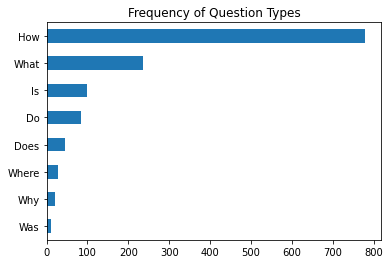

In [7]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

Tokenizing text for QA

In [8]:
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [9]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [10]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [11]:
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [12]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [13]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [14]:
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [15]:
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

[{'score': 0.26516106724739075,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22082959115505219,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253562033176422,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [16]:
!curl -X GET "localhost:9200/?pretty"

{

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   546  100   546    0     0  13166      0 --:--:-- --:--:-- --:--:-- 13650



  "name" : "7378097ea47b",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "QUfonRxxRtO_EmCQZ-6zhQ",
  "version" : {
    "number" : "7.17.0",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "bee86328705acaa9a6daede7140defd4d9ec56bd",
    "build_date" : "2022-01-28T08:36:04.875279988Z",
    "build_snapshot" : false,
    "lucene_version" : "8.11.1",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [17]:
# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

c:\users\antonio\pycharmprojects\simpletextclef\venv\lib\site-packages\elasticsearch\connection\base.py:190: ElasticsearchDeprecationWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)
02/03/2022 18:39:36 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:2.088s]
02/03/2022 18:39:36 - INFO - elasticsearch -   HEAD http://localhost:9200/document [status:200 request:0.010s]
02/03/2022 18:39:36 - INFO - elasticsearch -   GET http://localhost:9200/document [status:200 request:0.006s]
02/03/2022 18:39:36 - INFO - elasticsearch -   PUT http://localhost:9200/document/_mapping [status:200 request:0.100s]
02/03/2022 18:39:36 - INFO - elasticsearch -   HEAD http://localhost:9200/label [status:200 request:0.004s]


In [19]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"text": row["context"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

c:\users\antonio\pycharmprojects\simpletextclef\venv\lib\site-packages\elasticsearch\connection\base.py:190: ElasticsearchDeprecationWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)
02/03/2022 18:40:17 - INFO - elasticsearch -   HEAD http://localhost:9200/document [status:200 request:0.005s]
02/03/2022 18:40:19 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.457s]
02/03/2022 18:40:20 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.147s]
02/03/2022 18:40:21 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.089s]
02/03/2022 18:40:21 - INFO - elasticsearch -   HEAD http://localho

Loaded 1615 documents


In [20]:
es_retriever = ElasticsearchRetriever(document_store=document_store)

In [21]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

02/03/2022 18:40:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.020s]


In [22]:
retrieved_docs

[{'text': 'I really am enjoying my Kindle Fire HD. It does so many things. You can find plenty of free apps at Amazon.com. My favorite feature is watching movies on it. Splurged and joined Netflix. My husband and I have always disagreed on television programs. This way I can also enjoy my evening of relaxing. Also able to download plenty of free books and can lend books also. So far this product has exceeded my expectations. Would highly reccomend this. The size is perfect to carry with you. Tech support is A plus. Resolved my issue immediately.', 'score': None, 'probability': None, 'question': None, 'meta': {'item_id': 'B0074BW614', 'question_id': '991b7bc677086cc5ad62c997a35873ec', 'split': 'train'}, 'embedding': None, 'id': '10203f6344bf47631abab42f44984114'},
 {'text': 'Plays Netflix great, WiFi capability has great range. Resolution on the screen is AMAZING! For the price you cannot go wrong. Bought one for my spouse and myself after becoming addicted to hers! Our son LOVES it and

In [23]:
retrieved_docs[0]

{'text': 'I really am enjoying my Kindle Fire HD. It does so many things. You can find plenty of free apps at Amazon.com. My favorite feature is watching movies on it. Splurged and joined Netflix. My husband and I have always disagreed on television programs. This way I can also enjoy my evening of relaxing. Also able to download plenty of free books and can lend books also. So far this product has exceeded my expectations. Would highly reccomend this. The size is perfect to carry with you. Tech support is A plus. Resolved my issue immediately.', 'score': None, 'probability': None, 'question': None, 'meta': {'item_id': 'B0074BW614', 'question_id': '991b7bc677086cc5ad62c997a35873ec', 'split': 'train'}, 'embedding': None, 'id': '10203f6344bf47631abab42f44984114'}

In [24]:
model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

02/03/2022 18:40:23 - INFO - farm.utils -   Using device: CUDA 
02/03/2022 18:40:23 - INFO - farm.utils -   Number of GPUs: 1
02/03/2022 18:40:23 - INFO - farm.utils -   Distributed Training: False
02/03/2022 18:40:23 - INFO - farm.utils -   Automatic Mixed Precision: None
Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
02/03/2022 18:40:33 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be lo

In [25]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648081541061401, 'answers': [{'answer': '6000 hours', 'score': 10.699615478515625, 'probability': 0.3988131284713745, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offset_start': 38, 'offset_end': 48, 'offset_start_in_doc': 38, 'offset_end_in_doc': 48, 'document_id': 'e344757014e804eff50faa3ecf1c9c75'}]}


In [26]:
pipe = ExtractiveQAPipeline(reader, es_retriever)

In [28]:
n_answers = 3
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
                 filters={"item_id": [item_id], "split":["train"]})

print(f"Question: {preds['query']} \n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")
    print(f"Review snippet: ...{preds['answers'][idx]['context']}...")
    print("\n\n")

c:\users\antonio\pycharmprojects\simpletextclef\venv\lib\site-packages\elasticsearch\connection\base.py:190: ElasticsearchDeprecationWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)
02/03/2022 18:42:14 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.015s]


Question: Is it good for reading? 

Answer 1: it should be handy for me to play games or read a book
Review snippet: ...I choose the 7&#34; because we have a trike and it should be handy for me to play games or read a book while we are traveling down the road. It will  ...



Answer 2: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 3: I really am enjoying my Kindle Fire HD. It does so many things. You can find plenty of free apps at Amazon.com. My favorite feature is watching movies on it. Splurged and joined Netflix. My husband and I have always disagreed on television programs. This way I can also enjoy my evening of relaxing. Also able to download plenty of free books
Review snippet: ...I really am enjoying my Kindle Fire HD. It does so many things. You can find plenty of free apps at Amazon.c

In [37]:
class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvalDocuments()
        pipe = Pipeline()
        pipe.add_node(component=self.retriever, name="ESRetriever",
                      inputs=["Query"])
        pipe.add_node(component=self.eval_retriever, name="EvalRetriever",
                      inputs=["ESRetriever"])
        self.pipeline = pipe

In [38]:
pipe = EvalRetrieverPipeline(es_retriever)

In [45]:
labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                question=row["question"], answer=answer, id=i, origin=row["id"],
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False)
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            question=row["question"], answer="", id=i, origin=row["id"],
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True)
        labels.append(label)

In [46]:
print(labels[0])

{'id': '650aee54-bb0b-4b2b-af5b-eab2c9caea81', 'created_at': None, 'updated_at': None, 'question': 'What is the tonal balance of these headphones?', 'answer': 'I have been a headphone fanatic for thirty years', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd0781d13200014aa25860e44da9d5ea7', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00001WRSJ', 'question_id': 'd0781d13200014aa25860e44da9d5ea7'}}


In [47]:
document_store.write_labels(labels, index="label")
print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

c:\users\antonio\pycharmprojects\simpletextclef\venv\lib\site-packages\elasticsearch\connection\base.py:190: ElasticsearchDeprecationWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)
02/03/2022 19:16:38 - INFO - elasticsearch -   HEAD http://localhost:9200/label [status:200 request:0.005s]
02/03/2022 19:16:38 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:0.155s]


BulkIndexError: ('455 document(s) failed to index.', [{'index': {'_index': 'label', '_type': '_doc', '_id': '650aee54-bb0b-4b2b-af5b-eab2c9caea81', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '650aee54-bb0b-4b2b-af5b-eab2c9caea81'. Preview of field's value: 'I have been a headphone fanatic for thirty years'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 141}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the tonal balance of these headphones?', 'answer': 'I have been a headphone fanatic for thirty years', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd0781d13200014aa25860e44da9d5ea7', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00001WRSJ', 'question_id': 'd0781d13200014aa25860e44da9d5ea7'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '1', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '1'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 175}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How would you describe the texture of the lens at all focal lengths above 150mm?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b01740bc2d7f437398dfbb43073398a7', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00005LEN4', 'question_id': 'b01740bc2d7f437398dfbb43073398a7'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '2', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '2'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the thing?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'bfcaa4005b2a8c3c221cb97925a60c6f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00006B7DA', 'question_id': 'bfcaa4005b2a8c3c221cb97925a60c6f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '3', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '3'. Preview of field's value: 'I do recommend this lens'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you like the lens?', 'answer': 'I do recommend this lens', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7e34a94e6f5329a62ace7f956e4c5303', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00006I53S', 'question_id': '7e34a94e6f5329a62ace7f956e4c5303'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '4', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '4'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the contrast?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f549e9a738cf0d02079b078098752587', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00006I53S', 'question_id': 'f549e9a738cf0d02079b078098752587'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '5', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '5'. Preview of field's value: 'The cord is very long and durable'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 136}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is the cord safe to grab the transformer?', 'answer': 'The cord is very long and durable', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '31dafa4be0622f4f154590453c7562b5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00007E7C8', 'question_id': '31dafa4be0622f4f154590453c7562b5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '6', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '6'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you like the lens?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'fa3a1ed2f96dccc5f2df21f96030d02a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00007E7JU', 'question_id': 'fa3a1ed2f96dccc5f2df21f96030d02a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '7', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '7'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How does build quality work?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9cd1760c821a6348b0026c0e9739227c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00007E7JU', 'question_id': '9cd1760c821a6348b0026c0e9739227c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '8', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '8'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How are the camera picture?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '49b22c3fe24410d909ba35496ddb4c10', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00007E7JU', 'question_id': '49b22c3fe24410d909ba35496ddb4c10'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '9', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '9'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 127}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is build quality on lenses?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '04be283edd5a1fe4c710b301f74a7ce5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00007E7JU', 'question_id': '04be283edd5a1fe4c710b301f74a7ce5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '10', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '10'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is this a cheap construction?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6207510e7e3edf04fcdd3ef346ab671a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00007E7JU', 'question_id': '6207510e7e3edf04fcdd3ef346ab671a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '11', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '11'. Preview of field's value: 'build quality is cheap'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the quality of picture?', 'answer': 'build quality is cheap', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9ff07404dce2a09686a659a79cd4f5dd', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00007E7JU', 'question_id': '9ff07404dce2a09686a659a79cd4f5dd'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '12', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '12'. Preview of field's value: 'bokeh when shooting wide open'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 131}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the quality of the contrast?', 'answer': 'bokeh when shooting wide open', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0e4a387c553735189091e72e74e19222', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00007GQLU', 'question_id': '0e4a387c553735189091e72e74e19222'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '13', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '13'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the sound quality?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7d5c07d380a7ef3b5c64fa72b2ab3731', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00007M1TZ', 'question_id': '7d5c07d380a7ef3b5c64fa72b2ab3731'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '14', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '14'. Preview of field's value: 'cord is either too short and too long'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the cord like?', 'answer': 'cord is either too short and too long', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '47006bd3145448aabf92281eefdee61c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B000092YQW', 'question_id': '47006bd3145448aabf92281eefdee61c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '14', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '14'. Preview of field's value: 'the cord is either too short and too long'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the cord like?', 'answer': 'the cord is either too short and too long', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '47006bd3145448aabf92281eefdee61c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B000092YQW', 'question_id': '47006bd3145448aabf92281eefdee61c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '15', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '15'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Why is bag fairly  sturdy?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '47f48583f03449ee078065f02540f917', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00009R6TA', 'question_id': '47f48583f03449ee078065f02540f917'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '16', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '16'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is your bag full of lenses?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5270b859523bd4b80d573730269b6776', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00009R6TA', 'question_id': '5270b859523bd4b80d573730269b6776'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '17', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '17'. Preview of field's value: 'excellent buy'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 119}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the camera strap?', 'answer': 'excellent buy', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'a3096f0be5618744e5df997403fb0e0e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00009R6TA', 'question_id': 'a3096f0be5618744e5df997403fb0e0e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '17', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '17'. Preview of field's value: 'This backpack camera bag is an excellent buy'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 119}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the camera strap?', 'answer': 'This backpack camera bag is an excellent buy', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'a3096f0be5618744e5df997403fb0e0e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00009R6TA', 'question_id': 'a3096f0be5618744e5df997403fb0e0e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '18', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '18'. Preview of field's value: 'This lens is awesome'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the lens?', 'answer': 'This lens is awesome', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'cb6cdc1798c2a4b25d3b1149e73d3c10', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00009R6WT', 'question_id': 'cb6cdc1798c2a4b25d3b1149e73d3c10'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '18', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '18'. Preview of field's value: 'This lens is awesome'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the lens?', 'answer': 'This lens is awesome', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'cb6cdc1798c2a4b25d3b1149e73d3c10', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00009R6WT', 'question_id': 'cb6cdc1798c2a4b25d3b1149e73d3c10'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '19', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '19'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 175}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How would you describe the texture of the lens at all focal lengths above 150mm?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5b7f0cb1c385130cf83cedd0548bbbcb', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00009XVCZ', 'question_id': '5b7f0cb1c385130cf83cedd0548bbbcb'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '20', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '20'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 118}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do the lenses work?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3dc1865f7536450ee45bb0d74c031027', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00009XVCZ', 'question_id': '3dc1865f7536450ee45bb0d74c031027'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '21', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '21'. Preview of field's value: 'backgrounds'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the build quality like?', 'answer': 'backgrounds', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '835f4cca3566e87a5032ce5b44255579', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0000A1G05', 'question_id': '835f4cca3566e87a5032ce5b44255579'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '22', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '22'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 109}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is strap?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '19d6980d862e90d9170006eaa8516e58', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0000BZOGJ', 'question_id': '19d6980d862e90d9170006eaa8516e58'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '23', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '23'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How good is the phone?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '1d52cca372f67a00ebe76880d8715cbc', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0001FTVDQ', 'question_id': '1d52cca372f67a00ebe76880d8715cbc'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '24', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '24'. Preview of field's value: 'Range is excellent'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the range of this gun?', 'answer': 'Range is excellent', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '877b8c61459169d2f36aebf179889812', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0001FTVEK', 'question_id': '877b8c61459169d2f36aebf179889812'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '24', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '24'. Preview of field's value: 'Range is excellent, gets reception over 50 ft away'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the range of this gun?', 'answer': 'Range is excellent, gets reception over 50 ft away', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '877b8c61459169d2f36aebf179889812', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0001FTVEK', 'question_id': '877b8c61459169d2f36aebf179889812'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '25', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '25'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is the build quality okay?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'a39dbdcc7089ad732717e0786367abf7', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0002L5R78', 'question_id': 'a39dbdcc7089ad732717e0786367abf7'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '26', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '26'. Preview of field's value: 'The length is also good @ 2 meters'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 139}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Does this headphone cord has enought length?', 'answer': 'The length is also good @ 2 meters', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '01e73d7209f749ca4f76e5310ad4d64f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0002L5R78', 'question_id': '01e73d7209f749ca4f76e5310ad4d64f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '26', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '26'. Preview of field's value: 'The length is also good @ 2 meters'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 139}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Does this headphone cord has enought length?', 'answer': 'The length is also good @ 2 meters', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '01e73d7209f749ca4f76e5310ad4d64f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0002L5R78', 'question_id': '01e73d7209f749ca4f76e5310ad4d64f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '27', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '27'. Preview of field's value: 'my picture is stunning'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the picture?', 'answer': 'my picture is stunning', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2aed4f79a0aaf901decc86461ff5b1cd', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0002L5R78', 'question_id': '2aed4f79a0aaf901decc86461ff5b1cd'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '27', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '27'. Preview of field's value: 'my picture is stunning'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the picture?', 'answer': 'my picture is stunning', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2aed4f79a0aaf901decc86461ff5b1cd', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0002L5R78', 'question_id': '2aed4f79a0aaf901decc86461ff5b1cd'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '28', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '28'. Preview of field's value: 'This cable is good quality'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': 'This cable is good quality', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '555cccd1a515fb19215217699f563c9c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0002L5R78', 'question_id': '555cccd1a515fb19215217699f563c9c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '28', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '28'. Preview of field's value: 'Picture quality is simply stunning and there were no problems'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': 'Picture quality is simply stunning and there were no problems', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '555cccd1a515fb19215217699f563c9c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0002L5R78', 'question_id': '555cccd1a515fb19215217699f563c9c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '29', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '29'. Preview of field's value: 'I figure if 2300 has this much power'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 131}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How much is the power of the camera?', 'answer': 'I figure if 2300 has this much power', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'cad0fbc29c24d4a41f57035cffae3137', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0002SQ2P2', 'question_id': 'cad0fbc29c24d4a41f57035cffae3137'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '29', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '29'. Preview of field's value: 'I figure if 2300 has this much power'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 131}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How much is the power of the camera?', 'answer': 'I figure if 2300 has this much power', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'cad0fbc29c24d4a41f57035cffae3137', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0002SQ2P2', 'question_id': 'cad0fbc29c24d4a41f57035cffae3137'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '30', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '30'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 143}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the best price of a bag for travelling ?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4b7f4c3839c3261ea9d10df1a8b2c433', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0002Y5WZM', 'question_id': '4b7f4c3839c3261ea9d10df1a8b2c433'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '31', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '31'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the bag?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6c7cb5a4b3bc0afcba388d145a439688', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0002Y5WZM', 'question_id': '6c7cb5a4b3bc0afcba388d145a439688'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '32', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '32'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How can you issue?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8b390e92add7393d65e376ac2ad5f675', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000652M6Y', 'question_id': '8b390e92add7393d65e376ac2ad5f675'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '33', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '33'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How can you issue?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8395963522d93b45ff170c2dbaaaa4cb', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000652M6Y', 'question_id': '8395963522d93b45ff170c2dbaaaa4cb'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '34', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '34'. Preview of field's value: 'I give it 5 stars for indoor antennas'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the reception?', 'answer': 'I give it 5 stars for indoor antennas', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '84028225ba7b11b35e808932be08c43b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0007MXZB2', 'question_id': '84028225ba7b11b35e808932be08c43b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '35', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '35'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How many modes does the car have?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '850a401d27d2ba308d9a39bf66d50dd8', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0007QKMQY', 'question_id': '850a401d27d2ba308d9a39bf66d50dd8'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '36', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '36'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 136}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Where is there a good contrast of colors?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '888c4d505e0a84858504e3afdcf5e46a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0007U00X0', 'question_id': '888c4d505e0a84858504e3afdcf5e46a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '37', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '37'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 119}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the best layout?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '35eaf69575d2061595fbb5f2cceefc79', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000A6PPOK', 'question_id': '35eaf69575d2061595fbb5f2cceefc79'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '38', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '38'. Preview of field's value: 'level lenses'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What lenses do you prefer?', 'answer': 'level lenses', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'a8856a1e100f390aa60077a28abcfa13', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B000AZ57M6', 'question_id': 'a8856a1e100f390aa60077a28abcfa13'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '38', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '38'. Preview of field's value: 'The lens is built dust and weather resistant'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What lenses do you prefer?', 'answer': 'The lens is built dust and weather resistant', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'a8856a1e100f390aa60077a28abcfa13', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B000AZ57M6', 'question_id': 'a8856a1e100f390aa60077a28abcfa13'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '39', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '39'. Preview of field's value: 'on my 5d ii'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the lens?', 'answer': 'on my 5d ii', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '60989ff9230f632f3630cc65ece17859', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B000AZ57M6', 'question_id': '60989ff9230f632f3630cc65ece17859'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '39', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse field [answer] of type [flattened] in document with id \'39\'. Preview of field\'s value: \'this is a great all around lens and is my favorite for event photography and as my personal "walkabout" lens when I\'m on vacation\'', 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the lens?', 'answer': 'this is a great all around lens and is my favorite for event photography and as my personal "walkabout" lens when I\'m on vacation', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '60989ff9230f632f3630cc65ece17859', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B000AZ57M6', 'question_id': '60989ff9230f632f3630cc65ece17859'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '40', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '40'. Preview of field's value: 'This is a very basic item'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How are one was inexpensive?', 'answer': 'This is a very basic item', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '13e93cb3f9e387f971acb9602ed23a32', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B000BQ7GW8', 'question_id': '13e93cb3f9e387f971acb9602ed23a32'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '40', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '40'. Preview of field's value: 'the price was good'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How are one was inexpensive?', 'answer': 'the price was good', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '13e93cb3f9e387f971acb9602ed23a32', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B000BQ7GW8', 'question_id': '13e93cb3f9e387f971acb9602ed23a32'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '41', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '41'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 145}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is the software installed easy to use for novices?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '213e4ac56523c30b69d923f1e1df8d83', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000EPLP3C', 'question_id': '213e4ac56523c30b69d923f1e1df8d83'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '42', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '42'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 131}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How much is the power of the camera?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4a2c25c674251458c05a115db8f66f53', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000FBK3QK', 'question_id': '4a2c25c674251458c05a115db8f66f53'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '43', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '43'. Preview of field's value: 'The software that comes with it is great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is software?', 'answer': 'The software that comes with it is great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3efe1b99c73265e16e8aa77bc78b33be', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B000FBK3QK', 'question_id': '3efe1b99c73265e16e8aa77bc78b33be'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '44', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '44'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 127}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case of the new ipod?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6fad10d6c6e3910aaacfeccd2b32ebf9', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000HDJT4S', 'question_id': '6fad10d6c6e3910aaacfeccd2b32ebf9'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '45', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '45'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 133}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How can I have more usb port on my PC?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b67d10cd70c2d25babaa595d2aa6da7d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000Q8UAWY', 'question_id': 'b67d10cd70c2d25babaa595d2aa6da7d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '46', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '46'. Preview of field's value: 'Has 4 extra usb ports this is great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 133}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How can I have more usb port on my PC?', 'answer': 'Has 4 extra usb ports this is great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4bfbcafa609d52779ff3e860271854b0', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B000Q8UAWY', 'question_id': '4bfbcafa609d52779ff3e860271854b0'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '47', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '47'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 135}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What can you do when your phone is dead?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8ec9f512815d67c672b9a69d83b6af1b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000S5Q9CA', 'question_id': '8ec9f512815d67c672b9a69d83b6af1b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '48', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '48'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 136}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How would you define the quality of ones?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '91f7d57ad170839bcdf4a619bb7eaa23', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000S5Q9CA', 'question_id': '91f7d57ad170839bcdf4a619bb7eaa23'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '49', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '49'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 126}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What click are you looking for?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f4363f820b4abb6bb206518e98455dc4', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000TG4BA0', 'question_id': 'f4363f820b4abb6bb206518e98455dc4'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '50', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '50'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is possible to remove the dongle?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b8908e4794f6a798e96005cb6d4c28b0', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000TKHBDK', 'question_id': 'b8908e4794f6a798e96005cb6d4c28b0'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '51', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '51'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is possible to remove the dongle?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '80b91ecebfefe097cf82bbc3c2487fdf', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000TKHBDK', 'question_id': '80b91ecebfefe097cf82bbc3c2487fdf'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '52', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '52'. Preview of field's value: 'There is just so much to praise about this camera'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 133}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the size of the camera sensor?', 'answer': 'There is just so much to praise about this camera', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9901ef73e43be7acdf61055cc5f3728c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B000V5P90K', 'question_id': '9901ef73e43be7acdf61055cc5f3728c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '52', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '52'. Preview of field's value: 'large LCD screen'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 133}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the size of the camera sensor?', 'answer': 'large LCD screen', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9901ef73e43be7acdf61055cc5f3728c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B000V5P90K', 'question_id': '9901ef73e43be7acdf61055cc5f3728c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '53', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '53'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How can I know if this area is dance?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2509dc157eccc68ea1e1277dad6e7605', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000V9T2JA', 'question_id': '2509dc157eccc68ea1e1277dad6e7605'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '54', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '54'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Was the case loose?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '80f26fa58bcbd5766a406a3cf965692b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B000WOIFO2', 'question_id': '80f26fa58bcbd5766a406a3cf965692b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '55', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '55'. Preview of field's value: 'the software was quite straightforward'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is the software included good?', 'answer': 'the software was quite straightforward', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'de691b726c109451031bb88e558c4a06', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00119T6NQ', 'question_id': 'de691b726c109451031bb88e558c4a06'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '55', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '55'. Preview of field's value: '.  I find the software to be fairly intuitive'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is the software included good?', 'answer': '.  I find the software to be fairly intuitive', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'de691b726c109451031bb88e558c4a06', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00119T6NQ', 'question_id': 'de691b726c109451031bb88e558c4a06'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '56', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '56'. Preview of field's value: 'a heavier and bulkier lens'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the autofocus?', 'answer': 'a heavier and bulkier lens', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'be2fa6f767e869a638b18e9c730d7a71', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0011NVMO8', 'question_id': 'be2fa6f767e869a638b18e9c730d7a71'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '57', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '57'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the lens?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '04629d78470e15b114a9a6c2d26c840c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0011NVMO8', 'question_id': '04629d78470e15b114a9a6c2d26c840c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '58', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '58'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Why are things solid?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '23a7fcab311a6a40847aa582282669cf', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0012S4APK', 'question_id': '23a7fcab311a6a40847aa582282669cf'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '59', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '59'. Preview of field's value: 'picture is amazing'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': 'picture is amazing', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0c24e96e450af114bee55f660199b536', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B001413D94', 'question_id': '0c24e96e450af114bee55f660199b536'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '59', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '59'. Preview of field's value: 'The picture is amazing. It is so clear and sharp.'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': 'The picture is amazing. It is so clear and sharp.', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0c24e96e450af114bee55f660199b536', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B001413D94', 'question_id': '0c24e96e450af114bee55f660199b536'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '60', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '60'. Preview of field's value: 'For the people who complain about wire quality'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 135}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the quality sound on this device?', 'answer': 'For the people who complain about wire quality', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9ea0918236761f7a37e9e03265f9c4e6', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0015AE4CE', 'question_id': '9ea0918236761f7a37e9e03265f9c4e6'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '61', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '61'. Preview of field's value: 'The reception and sound are great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you like the reception?', 'answer': 'The reception and sound are great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c0c800add0e029b8d3dbe30168d22a55', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0016OEV7C', 'question_id': 'c0c800add0e029b8d3dbe30168d22a55'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '62', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '62'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How can I update the software?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '112a043ec0189cae1801ded1c88851e1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0018LX0DY', 'question_id': '112a043ec0189cae1801ded1c88851e1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '63', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '63'. Preview of field's value: 'The build quality of these is exceptional'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the construction of the cable?', 'answer': 'The build quality of these is exceptional', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c3a853b1ab2c9b36eeb17210902288f5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0019EHU8G', 'question_id': 'c3a853b1ab2c9b36eeb17210902288f5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '63', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '63'. Preview of field's value: 'The build quality of these is exceptional. They are thick and well shielded'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the construction of the cable?', 'answer': 'The build quality of these is exceptional. They are thick and well shielded', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c3a853b1ab2c9b36eeb17210902288f5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0019EHU8G', 'question_id': 'c3a853b1ab2c9b36eeb17210902288f5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '64', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '64'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Can I get the best quality cord ?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2ad4fadfbfc42b0e2d7e943ffa8f0472', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0019EHU8G', 'question_id': '2ad4fadfbfc42b0e2d7e943ffa8f0472'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '65', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '65'. Preview of field's value: 'is a sturdy, well-constructed product that does the job and this certainly does that'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the cord?', 'answer': 'is a sturdy, well-constructed product that does the job and this certainly does that', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'add7a8316fcb19d2656f415fd187a371', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0019EHU8G', 'question_id': 'add7a8316fcb19d2656f415fd187a371'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '66', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '66'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is the thing flimsy?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8297e535fc9d3543bfe63212dca8c215', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B001B077PO', 'question_id': '8297e535fc9d3543bfe63212dca8c215'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '67', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '67'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you like number one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9e414000f5f5a540b2183ef1aee71214', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B001DO2XWA', 'question_id': '9e414000f5f5a540b2183ef1aee71214'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '68', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '68'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Which case do you prefer?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '46fe495179a6ef657349939c6bb9d516', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B001EPUQAE', 'question_id': '46fe495179a6ef657349939c6bb9d516'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '69', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '69'. Preview of field's value: 'The mids sound great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the mid?', 'answer': 'The mids sound great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd49e3149b2d4584b598d5d67a07112df', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B001EZYMF4', 'question_id': 'd49e3149b2d4584b598d5d67a07112df'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '70', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '70'. Preview of field's value: 'the Video was better'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is sports mode great?', 'answer': 'the Video was better', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd6fcdf5b52fa1529cc8d0020754e565d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B001G5ZTZO', 'question_id': 'd6fcdf5b52fa1529cc8d0020754e565d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '71', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '71'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Why do I have a large area?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '324c62834ee8660fe65a131bc8b115b7', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B001IYCMNA', 'question_id': '324c62834ee8660fe65a131bc8b115b7'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '72', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '72'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What software do you want to use?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'cc672572cd67a388a8a31f2a659945c2', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B001NEK2GE', 'question_id': 'cc672572cd67a388a8a31f2a659945c2'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '73', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '73'. Preview of field's value: 'The software is terrible'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the software?', 'answer': 'The software is terrible', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2608ebc621597812d89b1f89b02e2fc7', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B001NEK2GE', 'question_id': '2608ebc621597812d89b1f89b02e2fc7'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '73', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '73'. Preview of field's value: 'have to program the device every time you boot up'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the software?', 'answer': 'have to program the device every time you boot up', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2608ebc621597812d89b1f89b02e2fc7', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B001NEK2GE', 'question_id': '2608ebc621597812d89b1f89b02e2fc7'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '74', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '74'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How does build quality work?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '11588c7cc2b2aa413fb5027f909e4ccf', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B001P9EQH8', 'question_id': '11588c7cc2b2aa413fb5027f909e4ccf'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '75', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '75'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 107}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is cord?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3169218094fb9d9d785e8ecf0bfb82c6', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B001RB24S2', 'question_id': '3169218094fb9d9d785e8ecf0bfb82c6'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '76', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '76'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What lenses are beautiful?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0a4b6039c98f05b217e2da31084536e8', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B001S2PPT0', 'question_id': '0a4b6039c98f05b217e2da31084536e8'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '77', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '77'. Preview of field's value: 'image quality that will blow most consumer'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 129}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How quality is the photo pictures?', 'answer': 'image quality that will blow most consumer', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'cc4e1e8c206a5a4ad646863a0bf8b225', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B001S2PPT0', 'question_id': 'cc4e1e8c206a5a4ad646863a0bf8b225'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '78', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '78'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 137}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Where is the integral mouse of the laptop?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'baa4736bce0749cd6594ae8e4b067359', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B001S4OTS6', 'question_id': 'baa4736bce0749cd6594ae8e4b067359'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '79', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '79'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 106}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is it pic ?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '099d2973dd19b7c12ccddae0f5176000', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B001SER47O', 'question_id': '099d2973dd19b7c12ccddae0f5176000'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '80', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '80'. Preview of field's value: 'The LCD screen on the back is crisp, clear, and bright so you can see it even in daylight'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the lcd video screen?', 'answer': 'The LCD screen on the back is crisp, clear, and bright so you can see it even in daylight', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e2e6221b11f5fd7f972bc5f4239f7b85', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B001SER47O', 'question_id': 'e2e6221b11f5fd7f972bc5f4239f7b85'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '80', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '80'. Preview of field's value: 'The LCD screen on the back is crisp, clear, and bright'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the lcd video screen?', 'answer': 'The LCD screen on the back is crisp, clear, and bright', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e2e6221b11f5fd7f972bc5f4239f7b85', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B001SER47O', 'question_id': 'e2e6221b11f5fd7f972bc5f4239f7b85'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '81', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '81'. Preview of field's value: 'This bag is soo perfect'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the bag?', 'answer': 'This bag is soo perfect', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2db54fa9ea58716f565953d8c1699769', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B001TZUS98', 'question_id': '2db54fa9ea58716f565953d8c1699769'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '81', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '81'. Preview of field's value: 'This bag is soo perfect'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the bag?', 'answer': 'This bag is soo perfect', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2db54fa9ea58716f565953d8c1699769', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B001TZUS98', 'question_id': '2db54fa9ea58716f565953d8c1699769'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '82', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '82'. Preview of field's value: 'The strap could be softer and wider'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the strap?', 'answer': 'The strap could be softer and wider', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c7e5d0ceef2eaeda8282d71609bdaebb', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B001TZWNF0', 'question_id': 'c7e5d0ceef2eaeda8282d71609bdaebb'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '83', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '83'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 134}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture taken by the camera?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '96370b58c0eda042b14a508d6efa3853', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B001UE6MA2', 'question_id': '96370b58c0eda042b14a508d6efa3853'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '84', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '84'. Preview of field's value: 'am a die-hard Packers fan'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the antenna?', 'answer': 'am a die-hard Packers fan', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6e6fadb6c9aeca30f2288042b9474b5d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0024R4B5C', 'question_id': '6e6fadb6c9aeca30f2288042b9474b5d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '84', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '84'. Preview of field's value: 'antennas pretty extensively as a hobby'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the antenna?', 'answer': 'antennas pretty extensively as a hobby', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6e6fadb6c9aeca30f2288042b9474b5d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0024R4B5C', 'question_id': '6e6fadb6c9aeca30f2288042b9474b5d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '85', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '85'. Preview of field's value: 'than you're used to compared to Nikon or Zeiss lenses'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you like the lens?', 'answer': "than you're used to compared to Nikon or Zeiss lenses", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '62abb3cd9412115827eef7fcf75237bc', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0025EWXEU', 'question_id': '62abb3cd9412115827eef7fcf75237bc'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '85', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '85'. Preview of field's value: 'I have read a lot of negative press about this lens'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you like the lens?', 'answer': 'I have read a lot of negative press about this lens', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '62abb3cd9412115827eef7fcf75237bc', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0025EWXEU', 'question_id': '62abb3cd9412115827eef7fcf75237bc'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '86', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '86'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Which case do you prefer?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '491d470caa545ba440a1ddf2d38f4c1d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0026FCI2U', 'question_id': '491d470caa545ba440a1ddf2d38f4c1d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '87', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '87'. Preview of field's value: 'for $40 these are by far superior to any otherThere'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 133}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the price of this guitar cord?', 'answer': 'for $40 these are by far superior to any otherThere', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '31c2c9ce89f2357328d852ef7e514419', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0027VT6V4', 'question_id': '31c2c9ce89f2357328d852ef7e514419'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '88', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '88'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'When can I hear your voice?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8bea882502ab576de5670d005bfaddb0', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002BH3I9U', 'question_id': '8bea882502ab576de5670d005bfaddb0'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '89', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '89'. Preview of field's value: 'This mouse feels great and operates nicely when it is working'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 119}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the scroll wheel?', 'answer': 'This mouse feels great and operates nicely when it is working', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '382f6a7fed26cf0c7e168750d18a1398', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002DPUUKK', 'question_id': '382f6a7fed26cf0c7e168750d18a1398'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '90', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '90'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': "Why don't you bring your bag?", 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f1720286c832713545979d9573439243', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002DW99H8', 'question_id': 'f1720286c832713545979d9573439243'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '91', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '91'. Preview of field's value: 'The mouse is very smooth and easy to use'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Was the mouse you had perfectly good?', 'answer': 'The mouse is very smooth and easy to use', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9f9754f4911a17fc57ac6abff74474fc', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002HWRJBM', 'question_id': '9f9754f4911a17fc57ac6abff74474fc'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '91', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '91'. Preview of field's value: 'The mouse is very smooth and easy to use'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Was the mouse you had perfectly good?', 'answer': 'The mouse is very smooth and easy to use', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9f9754f4911a17fc57ac6abff74474fc', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002HWRJBM', 'question_id': '9f9754f4911a17fc57ac6abff74474fc'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '92', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '92'. Preview of field's value: 'I understand it has an extremely high'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 126}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What click are you looking for?', 'answer': 'I understand it has an extremely high', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'cef32bee8a1c93e746e1e226fd40cbbb', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002HWRJBM', 'question_id': 'cef32bee8a1c93e746e1e226fd40cbbb'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '92', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '92'. Preview of field's value: 'This is a very nice mouse'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 126}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What click are you looking for?', 'answer': 'This is a very nice mouse', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'cef32bee8a1c93e746e1e226fd40cbbb', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002HWRJBM', 'question_id': 'cef32bee8a1c93e746e1e226fd40cbbb'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '93', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '93'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 129}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Do this computer comes with mouse?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c79e6dfba1545d98f20ef281c0de5c1f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002HWRJBM', 'question_id': 'c79e6dfba1545d98f20ef281c0de5c1f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '94', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '94'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How comfortable is your mouse?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'cd089134466b2c2330d74049d860647a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002HWRJBM', 'question_id': 'cd089134466b2c2330d74049d860647a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '95', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '95'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the quality of one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9641a0e19ffd2f84e31d4f06d2054d6e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002HWRJBM', 'question_id': '9641a0e19ffd2f84e31d4f06d2054d6e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '96', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '96'. Preview of field's value: '(Update)This mouse suddenly started working for me after months of the frustrations I listed below'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the new mouse?', 'answer': '(Update)This mouse suddenly started working for me after months of the frustrations I listed below', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '956ec768402c25003943dd6749f7e2f0', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002HWRJBM', 'question_id': '956ec768402c25003943dd6749f7e2f0'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '96', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '96'. Preview of field's value: 'The cursor will flake out every once in a while but it's usable as a mouse at this point'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the new mouse?', 'answer': "The cursor will flake out every once in a while but it's usable as a mouse at this point", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '956ec768402c25003943dd6749f7e2f0', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002HWRJBM', 'question_id': '956ec768402c25003943dd6749f7e2f0'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '97', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '97'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How can you issue?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4dbf5d2ff9964808f091df990e3e63e4', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002HWRJY4', 'question_id': '4dbf5d2ff9964808f091df990e3e63e4'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '98', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '98'. Preview of field's value: 'I didn't get any range improvement in one area of my house and my main laptop is still around -60db'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the range?', 'answer': "I didn't get any range improvement in one area of my house and my main laptop is still around -60db", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5b4f857254722d02ab95fd9fe5685756', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002HWRJY4', 'question_id': '5b4f857254722d02ab95fd9fe5685756'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '98', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '98'. Preview of field's value: 'the range is so short that it is practically unusable'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the range?', 'answer': 'the range is so short that it is practically unusable', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5b4f857254722d02ab95fd9fe5685756', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002HWRJY4', 'question_id': '5b4f857254722d02ab95fd9fe5685756'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '99', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '99'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 162}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How would a concise review describe the video quality, in one word?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '06c6c6a709d9dd5c3efaa1760bd0f52f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002IKLJU0', 'question_id': '06c6c6a709d9dd5c3efaa1760bd0f52f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '100', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '100'. Preview of field's value: 'The photos are clear and bright'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the photo?', 'answer': 'The photos are clear and bright', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'eabb2961f053e8a74ce6a898ad6e8e73', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002IKLJU0', 'question_id': 'eabb2961f053e8a74ce6a898ad6e8e73'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '100', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '100'. Preview of field's value: 'The photos are clear and bright'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the photo?', 'answer': 'The photos are clear and bright', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'eabb2961f053e8a74ce6a898ad6e8e73', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002IKLJU0', 'question_id': 'eabb2961f053e8a74ce6a898ad6e8e73'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '101', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '101'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the strap?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2889c170616d5c14d91ba863c916531f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002ISXBFI', 'question_id': '2889c170616d5c14d91ba863c916531f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '102', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '102'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the quality of the handle?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9e940b0b084cc8608c01a25492de2959', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002J9HBIO', 'question_id': '9e940b0b084cc8608c01a25492de2959'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '103', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '103'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 118}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is the power cable fit?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'aa2c3b6fbc513c93d28531b5443f13d6', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002J9HBIO', 'question_id': 'aa2c3b6fbc513c93d28531b5443f13d6'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '104', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '104'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 118}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'When did you see a one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5809730ff64769329866c421a409e913', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002J9HBIO', 'question_id': '5809730ff64769329866c421a409e913'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '105', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '105'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How does construction begin?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '99941184466d74bf9edc817be62b0d39', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002J9HBIO', 'question_id': '99941184466d74bf9edc817be62b0d39'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '106', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '106'. Preview of field's value: 'This small briefcase can be used for netbooks'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How fit  was the case?', 'answer': 'This small briefcase can be used for netbooks', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f12538bfeddf6b4dd1e9b6dd68c22353', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002J9HBIO', 'question_id': 'f12538bfeddf6b4dd1e9b6dd68c22353'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '107', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '107'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': "Why don't you bring your bag?", 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'af28775b8b98225246cef59daf5d8c81', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002J9HBIO', 'question_id': 'af28775b8b98225246cef59daf5d8c81'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '108', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse field [answer] of type [flattened] in document with id \'108\'. Preview of field\'s value: \'I am a 39 year old male and this review is for the Zune HD and what it is like to OWN one so that others may decide if they want one.  First off, you will notice that this review is "Amazon Verified" - yes, I purchased the Zune from Amazon and waited a couple of weeks to actually USE the product before submitting a review of it unlike some of the others here.  Enjoy....Packaging:The Zune comes in a nice small black box that slides open to reveal the contents which are the Zune HD, headphones, USB cable and some paperwork.  It\'s very stylish and nice.  Not much else to say as the box has been tucked away ever since opening.The look and feel:Ever since the first time I saw pictures on the net of the Zune HD I have wanted one.  Being a previous owner of a couple of different MP3 players the Zune was a must have just for the looks alone.  It really has nice lines and the color is just right; black and silver.  I hate this new term "sexy" and cringe when I hear a guy say it about an electronic device.  It does describe the Zune but I won\'t call it that.  The weight is very nice and it feels good in your hand.  I love the modern look and if they ever turned this device into a phone I would by one in a heartbeat!  I sometimes hold it to my ear and think, "WoW what a cool phone this would be."  The Zune logo on the back and a simple "ZUNE" on the front - very elegant.  On top is a power on button, the left side a volume rocker and the home button on the front.  The bottom is where you plug in your headphones and next to that is where the docking connector/USB cable plugs in.  It\'s the kind of device that has looks that will never get old and you want to just keep staring at it.  Very pleasing to have something you want everyone to see.The screen:OLED - it\'s the big talk these days.  I have a few pictures on my device right now and I have to say they look great.  The blacks are true blacks because the device shuts down the pixels where there should be black so you see true blacks and vibrant colors.  Outside I agree with most folks about the glare.  I have the brightness turned all the way up and it looks nice inside but outside the glare on the glass makes it as if you want to look at the reflection then back to what\'s on the screen.  I don\'t see this as a problem as I can\'t imagine any other electronic device no matter what it is not having this same problem.  For me, I can still see what is on the screen and have no problem with it.  It is just the right size at 3.3 inches.UI interface:Although inside the box there was no manual you would really have to be pretty stupid if you couldn\'t figure out how to navigate on this device.  Also, on the Zune web page is everything you need to know about how to work this device - who needs paper these days anyway???  The transitions from screen to screen are so fluid, smooth and animated.  The touch only needs to be light and it works flawlessly.  After using the device for a few minutes you get the idea of how to navigate.  You start off with a list of items to choose from on the main menu; pictures, music, apps, ect, etc.  As you click one you dive into that section and dive even deeper as you work what ever you have chosen clicking/touching away.  At all times the home button on the front will take you back to the main menu.  The accelerator zips from landscape to portrait very fast and smooth.  I really like that and feel the tegra chip inside is working for me without strain when I see this - video especially.  Multi touch works well and tapping is fine too especially on the web browser.  Everything is laid out nicely and there is no confusion about how to find something.  This is a plus for first timers and experienced users alike.Zune software: (APPS & Marketplace)This is a free download and helps you manage the Zune contents and updates.  The software mimics some of the icons on the Zune so you quickly identify the UI and what you need to click.  Syncing is a breeze and Zune will let you customize what content you want on the device and what you want Zune to do with it.  I have all of my MP3\'s in my music folder on my computer and it grabbed all of them when I plugged in for the first time with no problems.  There are some complaits about the software and how it takes forever to download - not true.  There are not a lot of apps right now.  I hope this blossoms as the months go by.  I have downloaded all of them so far as they are free but would gladly pay for any others if they should come about and would be useful.  The weather app is nice and lets you add as many cities as you want and shows you not only current conditions but a five day forecast as well.  The calculator well is a calculator.  The games have been just OK - I feel they do not utilize the Tegra chip but in the future I am sure the games will utilize the chip as it would be a waste if they didn\'t.  There is a chess game, Texas hold em, space ship shooter, a Bejeweled like game, soduku, and some game where you try to figure out where an item is hidden after mixing up three robots.  All are fun for a short while but I wait for more advanced cool games.  Also the games have ads just before they start - we are talking about 5 seconds of a video clip.  For a free download I think they have every right to put this here.  Also, FOUR to FIVE SECONDS is what we are talking about.  Is it that much time???  Patience!!!!  The marketplace is just something you need to experience.  Music, Videos, Podcasts and more.... EVERYTHING is here for you to choose from.  There is an option for a Zune pass and for $14.99 a month you can go nuts with this and download as much media as yo want - you get to keep 10 songs a month too.  This alone is worth buying the Zune HD.  There is so much content at the market place that I can\'t really explain.  Imagine walking into a store that has no one in it but you and the inventory consists of basically every kind of music you can think of as well as tons of other types of media just for you alone to walk up and down the isle to choose from.  I just hope for more apps in the future and (I know) this thing just came out so while I wait for apps I will enjoy my Zune....Docking station:I went with the basic Zune HD sync doc ($49) and lucked out with it.  There is an A/V dock you can purchase too($89).  I will tell you the only difference between the two is 1) the price and 2) the A/V doc comes with the HDMI and optical cables.  So if you already have these cables, which most of us do, save $40+ dollars and get the regular sync doc.  I have a review on the doc here on Amazon (where I purchased it) so check that out.  It is nice to just plug it in and sync and charge.  Also I can hook it up to a TV if I wanted or a receiver and utilize the Zune to transfer music and video to my home entertainment center.  The doc compliments the Zune and is very stylish looking and most importantly - Functional.Battery life:The OLED must be doing what it is supposed to do - save power.  I take the train every day to work from Milford, CT to Greenwich, CT and I can go about a week without charging using the Zune about an hour or so a day.  Wonderful! The only thing I have noticed is the back gets warm when in use.  Very strange.  I have been impressed with the battery and hope it stays that way.Screen protectors:I never had one before and at the time I received my Zune there was only Ghost Armor available.  I got one screen protector and had no problem putting it on but being a noob I didn\'t spray my fingers and my finger print was stuck on the adhesive side.  So I took it off.  Ghost armor was very nice and sent me a replacement but instead of just the screen protector they sent the full body armor - how nice of them!  This time around I was very careful and it went on with no problems BUT....I noticed the screen protector was about an eighth of an inch too short on top.  It was enough to bother me so I took it off.  (I know you are thinking I am nuts)  So I looked and found BodyGarudz on the net.  Not only do they sell TWO screen protectors for the price of ONE but it also fit perfectly.  I used the squeegee and applicator solution from Ghost to put the BodyGaurdz shield on - why?  Because BodyGaurdz\'s applicator solution wasn\'t as good as Ghosts and Ghost\'s squeegee was much better than BodyGaurdz.  So my insane suggestion - go with BodyGaurdz for the screen protector.  One other thing - the Ghost armor seems thicker - I can feel the sharp edges of the plastic now on the Zune because it has full body protection.  I hope they come out with some cool cases so I can rip this stuff off and throw more cash down the drain...!  The BodyGaurdz screen protector is thinner and looks great.Internet: (WiFi)The browser works well on the Zune HD.  I connected to my home network in seconds and at work it\'s even quicker.  You can tap and multi-touch to zoom in and move the pages around.  The keyboard is OK and can be used in landscape or portrait mode.  You can store pages in favorites and check AOL mail and what not.  It uses Bing to find what you are searching for.  I use it mostly for mail as at work the computers are restricted but WiFi is open.  You can sync via WiFi and download too which is very nice.Music (Sound):There is an internal equalizer with different settings depending on what type of music you are listening too.  It works OK - the music sounds fine to me.  I didn\'t use the supplied headphones as I have a pair of Sony Ear buds and they work better for my ears.  The music sounds great and the interface is cool - volume can be operated via the rocker on the side or touch screen.  Filtering music, making playlists and and just listening is a pleasure - this is what I got the device for - MUSIC - so everything else is just an added bonus to me.  I haven\'t bothered with the HD Radio much but it is cool to have. Remember...added bonus....Conclusion:I just love this Zune HD.  It really is functional for what I need it to do and the style, look and feel are just so right.  I hope this review helps you in your decision.  I will continue to update this review in the future so check back and best of luck to you and take care! ANSWERNOTFOUND\'', 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 133}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How many radio collection do you have?', 'answer': 'I am a 39 year old male and this review is for the Zune HD and what it is like to OWN one so that others may decide if they want one.  First off, you will notice that this review is "Amazon Verified" - yes, I purchased the Zune from Amazon and waited a couple of weeks to actually USE the product before submitting a review of it unlike some of the others here.  Enjoy....Packaging:The Zune comes in a nice small black box that slides open to reveal the contents which are the Zune HD, headphones, USB cable and some paperwork.  It\'s very stylish and nice.  Not much else to say as the box has been tucked away ever since opening.The look and feel:Ever since the first time I saw pictures on the net of the Zune HD I have wanted one.  Being a previous owner of a couple of different MP3 players the Zune was a must have just for the looks alone.  It really has nice lines and the color is just right; black and silver.  I hate this new term "sexy" and cringe when I hear a guy say it about an electronic device.  It does describe the Zune but I won\'t call it that.  The weight is very nice and it feels good in your hand.  I love the modern look and if they ever turned this device into a phone I would by one in a heartbeat!  I sometimes hold it to my ear and think, "WoW what a cool phone this would be."  The Zune logo on the back and a simple "ZUNE" on the front - very elegant.  On top is a power on button, the left side a volume rocker and the home button on the front.  The bottom is where you plug in your headphones and next to that is where the docking connector/USB cable plugs in.  It\'s the kind of device that has looks that will never get old and you want to just keep staring at it.  Very pleasing to have something you want everyone to see.The screen:OLED - it\'s the big talk these days.  I have a few pictures on my device right now and I have to say they look great.  The blacks are true blacks because the device shuts down the pixels where there should be black so you see true blacks and vibrant colors.  Outside I agree with most folks about the glare.  I have the brightness turned all the way up and it looks nice inside but outside the glare on the glass makes it as if you want to look at the reflection then back to what\'s on the screen.  I don\'t see this as a problem as I can\'t imagine any other electronic device no matter what it is not having this same problem.  For me, I can still see what is on the screen and have no problem with it.  It is just the right size at 3.3 inches.UI interface:Although inside the box there was no manual you would really have to be pretty stupid if you couldn\'t figure out how to navigate on this device.  Also, on the Zune web page is everything you need to know about how to work this device - who needs paper these days anyway???  The transitions from screen to screen are so fluid, smooth and animated.  The touch only needs to be light and it works flawlessly.  After using the device for a few minutes you get the idea of how to navigate.  You start off with a list of items to choose from on the main menu; pictures, music, apps, ect, etc.  As you click one you dive into that section and dive even deeper as you work what ever you have chosen clicking/touching away.  At all times the home button on the front will take you back to the main menu.  The accelerator zips from landscape to portrait very fast and smooth.  I really like that and feel the tegra chip inside is working for me without strain when I see this - video especially.  Multi touch works well and tapping is fine too especially on the web browser.  Everything is laid out nicely and there is no confusion about how to find something.  This is a plus for first timers and experienced users alike.Zune software: (APPS & Marketplace)This is a free download and helps you manage the Zune contents and updates.  The software mimics some of the icons on the Zune so you quickly identify the UI and what you need to click.  Syncing is a breeze and Zune will let you customize what content you want on the device and what you want Zune to do with it.  I have all of my MP3\'s in my music folder on my computer and it grabbed all of them when I plugged in for the first time with no problems.  There are some complaits about the software and how it takes forever to download - not true.  There are not a lot of apps right now.  I hope this blossoms as the months go by.  I have downloaded all of them so far as they are free but would gladly pay for any others if they should come about and would be useful.  The weather app is nice and lets you add as many cities as you want and shows you not only current conditions but a five day forecast as well.  The calculator well is a calculator.  The games have been just OK - I feel they do not utilize the Tegra chip but in the future I am sure the games will utilize the chip as it would be a waste if they didn\'t.  There is a chess game, Texas hold em, space ship shooter, a Bejeweled like game, soduku, and some game where you try to figure out where an item is hidden after mixing up three robots.  All are fun for a short while but I wait for more advanced cool games.  Also the games have ads just before they start - we are talking about 5 seconds of a video clip.  For a free download I think they have every right to put this here.  Also, FOUR to FIVE SECONDS is what we are talking about.  Is it that much time???  Patience!!!!  The marketplace is just something you need to experience.  Music, Videos, Podcasts and more.... EVERYTHING is here for you to choose from.  There is an option for a Zune pass and for $14.99 a month you can go nuts with this and download as much media as yo want - you get to keep 10 songs a month too.  This alone is worth buying the Zune HD.  There is so much content at the market place that I can\'t really explain.  Imagine walking into a store that has no one in it but you and the inventory consists of basically every kind of music you can think of as well as tons of other types of media just for you alone to walk up and down the isle to choose from.  I just hope for more apps in the future and (I know) this thing just came out so while I wait for apps I will enjoy my Zune....Docking station:I went with the basic Zune HD sync doc ($49) and lucked out with it.  There is an A/V dock you can purchase too($89).  I will tell you the only difference between the two is 1) the price and 2) the A/V doc comes with the HDMI and optical cables.  So if you already have these cables, which most of us do, save $40+ dollars and get the regular sync doc.  I have a review on the doc here on Amazon (where I purchased it) so check that out.  It is nice to just plug it in and sync and charge.  Also I can hook it up to a TV if I wanted or a receiver and utilize the Zune to transfer music and video to my home entertainment center.  The doc compliments the Zune and is very stylish looking and most importantly - Functional.Battery life:The OLED must be doing what it is supposed to do - save power.  I take the train every day to work from Milford, CT to Greenwich, CT and I can go about a week without charging using the Zune about an hour or so a day.  Wonderful! The only thing I have noticed is the back gets warm when in use.  Very strange.  I have been impressed with the battery and hope it stays that way.Screen protectors:I never had one before and at the time I received my Zune there was only Ghost Armor available.  I got one screen protector and had no problem putting it on but being a noob I didn\'t spray my fingers and my finger print was stuck on the adhesive side.  So I took it off.  Ghost armor was very nice and sent me a replacement but instead of just the screen protector they sent the full body armor - how nice of them!  This time around I was very careful and it went on with no problems BUT....I noticed the screen protector was about an eighth of an inch too short on top.  It was enough to bother me so I took it off.  (I know you are thinking I am nuts)  So I looked and found BodyGarudz on the net.  Not only do they sell TWO screen protectors for the price of ONE but it also fit perfectly.  I used the squeegee and applicator solution from Ghost to put the BodyGaurdz shield on - why?  Because BodyGaurdz\'s applicator solution wasn\'t as good as Ghosts and Ghost\'s squeegee was much better than BodyGaurdz.  So my insane suggestion - go with BodyGaurdz for the screen protector.  One other thing - the Ghost armor seems thicker - I can feel the sharp edges of the plastic now on the Zune because it has full body protection.  I hope they come out with some cool cases so I can rip this stuff off and throw more cash down the drain...!  The BodyGaurdz screen protector is thinner and looks great.Internet: (WiFi)The browser works well on the Zune HD.  I connected to my home network in seconds and at work it\'s even quicker.  You can tap and multi-touch to zoom in and move the pages around.  The keyboard is OK and can be used in landscape or portrait mode.  You can store pages in favorites and check AOL mail and what not.  It uses Bing to find what you are searching for.  I use it mostly for mail as at work the computers are restricted but WiFi is open.  You can sync via WiFi and download too which is very nice.Music (Sound):There is an internal equalizer with different settings depending on what type of music you are listening too.  It works OK - the music sounds fine to me.  I didn\'t use the supplied headphones as I have a pair of Sony Ear buds and they work better for my ears.  The music sounds great and the interface is cool - volume can be operated via the rocker on the side or touch screen.  Filtering music, making playlists and and just listening is a pleasure - this is what I got the device for - MUSIC - so everything else is just an added bonus to me.  I haven\'t bothered with the HD Radio much but it is cool to have. Remember...added bonus....Conclusion:I just love this Zune HD.  It really is functional for what I need it to do and the style, look and feel are just so right.  I hope this review helps you in your decision.  I will continue to update this review in the future so check back and best of luck to you and take care! ANSWERNOTFOUND', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7aca8595bd4ae758358e0daaaf81a0b0', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002JPITXY', 'question_id': '7aca8595bd4ae758358e0daaaf81a0b0'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '109', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '109'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the build quality?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'ce5c6af783a0074b5d4ae2c7283d7abc', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002JPITXY', 'question_id': 'ce5c6af783a0074b5d4ae2c7283d7abc'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '110', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '110'. Preview of field's value: 'course'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the photo?', 'answer': 'course', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '565999c9710d9c24a156556ff4dbbbe9', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002LITT42', 'question_id': '565999c9710d9c24a156556ff4dbbbe9'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '110', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '110'. Preview of field's value: 'MUCH better pictures in low light'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the photo?', 'answer': 'MUCH better pictures in low light', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '565999c9710d9c24a156556ff4dbbbe9', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002LITT42', 'question_id': '565999c9710d9c24a156556ff4dbbbe9'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '111', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '111'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 134}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the camera lens is one of worse?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'eba5c96d169d29022dc9f42b743f4f5e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002MAPRYU', 'question_id': 'eba5c96d169d29022dc9f42b743f4f5e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '112', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '112'. Preview of field's value: 'the fan is really really good'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How does the fan work?', 'answer': 'the fan is really really good', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5a9b7616541f700f103d21f8ad41bc4b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002MU1ZRS', 'question_id': '5a9b7616541f700f103d21f8ad41bc4b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '113', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '113'. Preview of field's value: 'this cooler fits it just about perfectly'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How does the fan work?', 'answer': 'this cooler fits it just about perfectly', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f20dae56410f31632d6a9f8f8284657a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002MU1ZRS', 'question_id': 'f20dae56410f31632d6a9f8f8284657a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '113', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '113'. Preview of field's value: 'the fan itself isn't super loud. There is an adjustable dial to change fan speed'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How does the fan work?', 'answer': "the fan itself isn't super loud. There is an adjustable dial to change fan speed", 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f20dae56410f31632d6a9f8f8284657a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002MU1ZRS', 'question_id': 'f20dae56410f31632d6a9f8f8284657a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '114', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '114'. Preview of field's value: 'The image quality was good on this camera but the speed was lacking'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is it picture ?', 'answer': 'The image quality was good on this camera but the speed was lacking', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'aa6fb93883652de3ba445034d538cf2b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002NEGTTW', 'question_id': 'aa6fb93883652de3ba445034d538cf2b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '115', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '115'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the year of this one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5b2fe5102e279d980c5ac7e147be7d2f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002QEBMAK', 'question_id': '5b2fe5102e279d980c5ac7e147be7d2f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '116', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '116'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is the video quality good?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '340bb728e6789a5b86199c5169a7c2de', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002R5AM7C', 'question_id': '340bb728e6789a5b86199c5169a7c2de'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '117', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '117'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3ce3e41d828d818e49418adeaaaaae8e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002R5AM7C', 'question_id': '3ce3e41d828d818e49418adeaaaaae8e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '118', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '118'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 130}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Which there a wireless  capability?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b7235d940f8e80dd6b51be8980804105', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002RM08RE', 'question_id': 'b7235d940f8e80dd6b51be8980804105'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '119', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '119'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is usb port working?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '064abb442be3957fccd7193c0e19be2f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002SGATH8', 'question_id': '064abb442be3957fccd7193c0e19be2f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '120', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '120'. Preview of field's value: 'Don't expect to always get the 150Mbps'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How slow is the internet service?', 'answer': "Don't expect to always get the 150Mbps", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '481ce7605d0806026703b0e831862b4f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002SZEOLG', 'question_id': '481ce7605d0806026703b0e831862b4f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '120', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '120'. Preview of field's value: '150Mbps'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How slow is the internet service?', 'answer': '150Mbps', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '481ce7605d0806026703b0e831862b4f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002SZEOLG', 'question_id': '481ce7605d0806026703b0e831862b4f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '121', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '121'. Preview of field's value: 'However outside, in my car placed this unit on the dashboard'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the capability?', 'answer': 'However outside, in my car placed this unit on the dashboard', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c743ecd3d10fd0331b07da45a6068336', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002SZEOLG', 'question_id': 'c743ecd3d10fd0331b07da45a6068336'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '121', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '121'. Preview of field's value: 'this antenna ranked equally with the built'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the capability?', 'answer': 'this antenna ranked equally with the built', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c743ecd3d10fd0331b07da45a6068336', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002SZEOLG', 'question_id': 'c743ecd3d10fd0331b07da45a6068336'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '122', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '122'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the capability?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b0811c1892e1ff6e300d5947a852a8a4', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002SZEOLG', 'question_id': 'b0811c1892e1ff6e300d5947a852a8a4'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '123', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '123'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How resistant is the strap?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'be5e4b607e936b6097dc7e4aa35f36e0', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B002VPE1WK', 'question_id': 'be5e4b607e936b6097dc7e4aa35f36e0'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '124', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '124'. Preview of field's value: 'A very high quality bag for your DSLR'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the bag?', 'answer': 'A very high quality bag for your DSLR', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd8e55264aa0ec4c77a36a8133ab1c7cc', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002VPE1WK', 'question_id': 'd8e55264aa0ec4c77a36a8133ab1c7cc'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '125', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '125'. Preview of field's value: 'this mouse is awesome'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What quality is the mouse?', 'answer': 'this mouse is awesome', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8625e70a991a0f338b43db58eed88242', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002Y6CJJ8', 'question_id': '8625e70a991a0f338b43db58eed88242'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '125', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '125'. Preview of field's value: 'its the best mouse ive ever had'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What quality is the mouse?', 'answer': 'its the best mouse ive ever had', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8625e70a991a0f338b43db58eed88242', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B002Y6CJJ8', 'question_id': '8625e70a991a0f338b43db58eed88242'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '126', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '126'. Preview of field's value: 'how good the picture was'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 134}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture taken by the camera?', 'answer': 'how good the picture was', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '53e354b132919e5c204696997ebec8d6', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0030MITDK', 'question_id': '53e354b132919e5c204696997ebec8d6'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '126', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '126'. Preview of field's value: 'that tiny little camera you were carrying around'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 134}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture taken by the camera?', 'answer': 'that tiny little camera you were carrying around', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '53e354b132919e5c204696997ebec8d6', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0030MITDK', 'question_id': '53e354b132919e5c204696997ebec8d6'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '127', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '127'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '41c049a7a01d29ca34510174d21df398', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0030MITDK', 'question_id': '41c049a7a01d29ca34510174d21df398'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '128', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '128'. Preview of field's value: 'These cables are great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 134}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Do you think the cable length is right?', 'answer': 'These cables are great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '792f3699913fedd194f28320839a5c66', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00316263Y', 'question_id': '792f3699913fedd194f28320839a5c66'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '128', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '128'. Preview of field's value: 'The cable is of'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 134}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Do you think the cable length is right?', 'answer': 'The cable is of', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '792f3699913fedd194f28320839a5c66', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00316263Y', 'question_id': '792f3699913fedd194f28320839a5c66'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '129', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '129'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 127}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What about handles of this bags?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5d766cbb1730dc64c91717354f32636d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0038KTAXW', 'question_id': '5d766cbb1730dc64c91717354f32636d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '130', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '130'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How good is the phone?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd27a40433e3e93f219743122c63e5d81', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0038W0K2K', 'question_id': 'd27a40433e3e93f219743122c63e5d81'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '131', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '131'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 135}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the quality sound on this device?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b672aa063d7a948af846448dd6054011', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0038W0K2K', 'question_id': 'b672aa063d7a948af846448dd6054011'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '132', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '132'. Preview of field's value: 'The bendy wire attached to the ear bud makes it hold tight to your ears.  The clip is pretty useless, and the pouch is really small.The sound is decent.  Not great.  It's a little tinny and lacks any real base, but everything is audible and there isn't a lot of noticeable distortion.I purchased these to replace a pair of Shure isolating ear buds.  Let's be real.  They are a cheap replacement.  The'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is it the fit?', 'answer': "The bendy wire attached to the ear bud makes it hold tight to your ears.  The clip is pretty useless, and the pouch is really small.The sound is decent.  Not great.  It's a little tinny and lacks any real base, but everything is audible and there isn't a lot of noticeable distortion.I purchased these to replace a pair of Shure isolating ear buds.  Let's be real.  They are a cheap replacement.  The", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '1c419643f353a137d1a23528d756581b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0038W0K2K', 'question_id': '1c419643f353a137d1a23528d756581b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '132', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '132'. Preview of field's value: 'provide great isolation'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is it the fit?', 'answer': 'provide great isolation', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '1c419643f353a137d1a23528d756581b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0038W0K2K', 'question_id': '1c419643f353a137d1a23528d756581b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '133', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '133'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is it a good photo?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c27f9ddc661cac995d8bc0d182da7668', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00395WIXA', 'question_id': 'c27f9ddc661cac995d8bc0d182da7668'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '134', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '134'. Preview of field's value: 'was easy and took right away'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is this thing hard to handle?', 'answer': 'was easy and took right away', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd8228319cea9457d3cd92af544c1affe', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0039H2W66', 'question_id': 'd8228319cea9457d3cd92af544c1affe'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '134', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '134'. Preview of field's value: 'The instructions were easy to follow'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is this thing hard to handle?', 'answer': 'The instructions were easy to follow', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd8228319cea9457d3cd92af544c1affe', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0039H2W66', 'question_id': 'd8228319cea9457d3cd92af544c1affe'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '135', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '135'. Preview of field's value: 'This product is easy to set up and works in my 2007 Pontiac G6 Convertible'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is this thing hard to handle?', 'answer': 'This product is easy to set up and works in my 2007 Pontiac G6 Convertible', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e3a01feeb3fbd54f6a55c86d163e55b5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0039H2W66', 'question_id': 'e3a01feeb3fbd54f6a55c86d163e55b5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '136', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '136'. Preview of field's value: 'the build of these headphones are solid'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 134}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the build quality on this place?', 'answer': 'the build of these headphones are solid', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'a63259e8dafbf5474c3d624502dc68ce', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003BYRGJU', 'question_id': 'a63259e8dafbf5474c3d624502dc68ce'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '137', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '137'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the presence of mid?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7a9661ab3d42506fa5d568d3f95d634d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003BYRGJU', 'question_id': '7a9661ab3d42506fa5d568d3f95d634d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '138', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '138'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the clarity of the screen?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '63c759450ef8b7d09e8147be2e4a1fac', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003ELYQGG', 'question_id': '63c759450ef8b7d09e8147be2e4a1fac'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '139', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '139'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is number one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3aadbb8c53a203024b06238c5488ba0a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003ELYQGG', 'question_id': '3aadbb8c53a203024b06238c5488ba0a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '140', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '140'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How about this thing?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '50fa8499d13e0f6ad9d580f1fef361a4', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003ELYQGG', 'question_id': '50fa8499d13e0f6ad9d580f1fef361a4'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '141', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '141'. Preview of field's value: 'Pretty basic ear peices'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the presence of mid?', 'answer': 'Pretty basic ear peices', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'bea4ff7974f94e3680c813489b6cd654', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003ELYQGG', 'question_id': 'bea4ff7974f94e3680c813489b6cd654'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '142', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '142'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the cord?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'a1ca982e9657500340baf1d95a1abade', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003ELYQGG', 'question_id': 'a1ca982e9657500340baf1d95a1abade'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '143', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '143'. Preview of field's value: 'the cord gets loose'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the cord?', 'answer': 'the cord gets loose', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'fba0789f417905bbb8a3d510873a5f67', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003ELYQGG', 'question_id': 'fba0789f417905bbb8a3d510873a5f67'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '143', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '143'. Preview of field's value: 'the cord gets loose at the earphone or at the jack'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the cord?', 'answer': 'the cord gets loose at the earphone or at the jack', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'fba0789f417905bbb8a3d510873a5f67', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003ELYQGG', 'question_id': 'fba0789f417905bbb8a3d510873a5f67'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '144', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '144'. Preview of field's value: 'The sound quality is clear and the bass loud'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the sound quality?', 'answer': 'The sound quality is clear and the bass loud', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'ea2db3a6f55f2077e326e32e01cfbfbb', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003ELYQGG', 'question_id': 'ea2db3a6f55f2077e326e32e01cfbfbb'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '145', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '145'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b8f465e380769705927c8a3eeeaa9e4e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003ELYQGG', 'question_id': 'b8f465e380769705927c8a3eeeaa9e4e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '146', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '146'. Preview of field's value: 'The cord itself is great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the cord?', 'answer': 'The cord itself is great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '52013c606876d8627ce1892f67675e43', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003ES5ZSW', 'question_id': '52013c606876d8627ce1892f67675e43'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '146', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '146'. Preview of field's value: 'cord itself is great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the cord?', 'answer': 'cord itself is great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '52013c606876d8627ce1892f67675e43', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003ES5ZSW', 'question_id': '52013c606876d8627ce1892f67675e43'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '147', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '147'. Preview of field's value: 'Picture looks great and no issues'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you like the picture?', 'answer': 'Picture looks great and no issues', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd6d105dadc93ca18d5295796d2530f94', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003ES5ZUU', 'question_id': 'd6d105dadc93ca18d5295796d2530f94'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '147', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '147'. Preview of field's value: 'Picture'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you like the picture?', 'answer': 'Picture', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd6d105dadc93ca18d5295796d2530f94', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003ES5ZUU', 'question_id': 'd6d105dadc93ca18d5295796d2530f94'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '148', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '148'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 134}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the quality of the construction?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6db978bc2568234a3a0d3d8ee7da0652', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003ES5ZUU', 'question_id': '6db978bc2568234a3a0d3d8ee7da0652'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '149', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '149'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the deal?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'fa093d06947142ea3fda83d016d42b6b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003ES5ZUU', 'question_id': 'fa093d06947142ea3fda83d016d42b6b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '150', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '150'. Preview of field's value: 'Picture quality is great as well as the quality of the cable'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': 'Picture quality is great as well as the quality of the cable', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '118330e21adb74ae1cac7f9fc7664bbe', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003ES5ZUU', 'question_id': '118330e21adb74ae1cac7f9fc7664bbe'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '150', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '150'. Preview of field's value: 'Picture quality is great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': 'Picture quality is great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '118330e21adb74ae1cac7f9fc7664bbe', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003ES5ZUU', 'question_id': '118330e21adb74ae1cac7f9fc7664bbe'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '151', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '151'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is that thing?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '44e9d0b2cd6ff85dc2dc53ff47e94616', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003ES5ZUU', 'question_id': '44e9d0b2cd6ff85dc2dc53ff47e94616'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '152', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '152'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the cord?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2b19317d799bf636feec9bd370f21127', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003GIJTR8', 'question_id': '2b19317d799bf636feec9bd370f21127'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '153', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '153'. Preview of field's value: 'I think that the performance (colors, contrast, brightness) is very good for home use'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 131}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the quality of the contrast?', 'answer': 'I think that the performance (colors, contrast, brightness) is very good for home use', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5a995fb4bb6ea1556a9cc6419fe9975d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003HFCDLY', 'question_id': '5a995fb4bb6ea1556a9cc6419fe9975d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '154', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '154'. Preview of field's value: 'beautiful contrast'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 136}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Where is there a good contrast of colors?', 'answer': 'beautiful contrast', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '11fa27f0a6d4eba4a92a6a1f7cb85db1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003HFCDLY', 'question_id': '11fa27f0a6d4eba4a92a6a1f7cb85db1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '154', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '154'. Preview of field's value: 'It just appears the buttons are flush into the glossy bevel'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 136}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Where is there a good contrast of colors?', 'answer': 'It just appears the buttons are flush into the glossy bevel', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '11fa27f0a6d4eba4a92a6a1f7cb85db1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003HFCDLY', 'question_id': '11fa27f0a6d4eba4a92a6a1f7cb85db1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '155', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '155'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 141}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the tonal balance of these headphones?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '11ffc0cb4a4c84785cf24dbaa10ce4fd', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003LPTAYI', 'question_id': '11ffc0cb4a4c84785cf24dbaa10ce4fd'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '156', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '156'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 118}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Do you thing different?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '17317795c59bd32ab21872e5e6fd05c7', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003LR7ME6', 'question_id': '17317795c59bd32ab21872e5e6fd05c7'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '157', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '157'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f7fe2e612d648803b78bdb07db5ebab6', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003LR7ME6', 'question_id': 'f7fe2e612d648803b78bdb07db5ebab6'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '158', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '158'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 107}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is case?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '024155d84739000816215ef52757adb0', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003LR7ME6', 'question_id': '024155d84739000816215ef52757adb0'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '159', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '159'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'df0b5d4922ac6596f1b0a03f7f702591', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003LR7ME6', 'question_id': 'df0b5d4922ac6596f1b0a03f7f702591'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '160', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '160'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 134}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the sensitivity and selectivity?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd7a2ac7bb9e0b2804c5aa67577fce615', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003NR57BY', 'question_id': 'd7a2ac7bb9e0b2804c5aa67577fce615'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '161', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '161'. Preview of field's value: 'This is a great wireless mouse'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the mouse?', 'answer': 'This is a great wireless mouse', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '59e849962451def9d0a6136148df4f39', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003NR57BY', 'question_id': '59e849962451def9d0a6136148df4f39'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '161', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '161'. Preview of field's value: 'This is a great wireless mouse'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the mouse?', 'answer': 'This is a great wireless mouse', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '59e849962451def9d0a6136148df4f39', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003NR57BY', 'question_id': '59e849962451def9d0a6136148df4f39'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '162', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '162'. Preview of field's value: 'outstanding recording quality'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Was the audio quality good?', 'answer': 'outstanding recording quality', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '45098996eb59d3c7cac0400c42724d1f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003QKBVYK', 'question_id': '45098996eb59d3c7cac0400c42724d1f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '163', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '163'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the range of the house?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '239f875c629bb96ed0947b0b83d6e7d3', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003UE52ME', 'question_id': '239f875c629bb96ed0947b0b83d6e7d3'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '164', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '164'. Preview of field's value: 'I have medium sized hand'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How big is your hand?', 'answer': 'I have medium sized hand', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9553e3e1dc2005e3b6f54bc677a0d917', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003UT6C9G', 'question_id': '9553e3e1dc2005e3b6f54bc677a0d917'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '164', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '164'. Preview of field's value: 'I have medium sized hand'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How big is your hand?', 'answer': 'I have medium sized hand', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9553e3e1dc2005e3b6f54bc677a0d917', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003UT6C9G', 'question_id': '9553e3e1dc2005e3b6f54bc677a0d917'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '165', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '165'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is the best mouse?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '92b5511fec55d43888279686b9953b4a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003VAHYNC', 'question_id': '92b5511fec55d43888279686b9953b4a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '166', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '166'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Was the mouse you had perfectly good?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '46f0cc43eabad7a1155d466e994a4806', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003VAHYNC', 'question_id': '46f0cc43eabad7a1155d466e994a4806'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '167', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '167'. Preview of field's value: 'This mouse is excellent for gaming'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 118}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What size is the mouse?', 'answer': 'This mouse is excellent for gaming', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b0dd4d7affb1237dc26944527881bfb5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003VAM32E', 'question_id': 'b0dd4d7affb1237dc26944527881bfb5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '167', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '167'. Preview of field's value: 'mouse wheel jiggles'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 118}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What size is the mouse?', 'answer': 'mouse wheel jiggles', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b0dd4d7affb1237dc26944527881bfb5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003VAM32E', 'question_id': 'b0dd4d7affb1237dc26944527881bfb5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '168', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '168'. Preview of field's value: 'and quality is great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'and quality is great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9ec537c6af6d0e948666692b0ff3d7e3', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003VVH8Y6', 'question_id': '9ec537c6af6d0e948666692b0ff3d7e3'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '168', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '168'. Preview of field's value: 'this case is perfect'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'this case is perfect', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9ec537c6af6d0e948666692b0ff3d7e3', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003VVH8Y6', 'question_id': '9ec537c6af6d0e948666692b0ff3d7e3'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '169', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '169'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '249cee66615ba39b11ffc4cfe75e8059', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003VVH8Y6', 'question_id': '249cee66615ba39b11ffc4cfe75e8059'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '170', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '170'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is a soft interior?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '40d84c39410975f87e69063c425627a9', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003WUBIZQ', 'question_id': '40d84c39410975f87e69063c425627a9'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '171', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '171'. Preview of field's value: 'thank'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 118}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is that fan so big?', 'answer': 'thank', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd360558944a93c6ce51748bf7aece121', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003XN24GY', 'question_id': 'd360558944a93c6ce51748bf7aece121'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '172', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '172'. Preview of field's value: 'Highly recommended'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the quality of case?', 'answer': 'Highly recommended', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4b7c8fd57edc541f33e7f900c0e0ff24', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003ZUIHY8', 'question_id': '4b7c8fd57edc541f33e7f900c0e0ff24'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '172', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '172'. Preview of field's value: 'They were correct as my case is awesome'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the quality of case?', 'answer': 'They were correct as my case is awesome', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4b7c8fd57edc541f33e7f900c0e0ff24', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B003ZUIHY8', 'question_id': '4b7c8fd57edc541f33e7f900c0e0ff24'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '173', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '173'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 118}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How does this fan work?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e5695f48db0555d19ba54604634b01f3', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B003ZUXXWO', 'question_id': 'e5695f48db0555d19ba54604634b01f3'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '174', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '174'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 131}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How easy to install is the software?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5a2bc139f8b511a35a684a31e27e4c96', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0043T7FXE', 'question_id': '5a2bc139f8b511a35a684a31e27e4c96'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '175', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '175'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 131}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How easy to install is the software?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4dea9fff38f2baf854758f4b9609ddcb', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0043T7FXE', 'question_id': '4dea9fff38f2baf854758f4b9609ddcb'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '176', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '176'. Preview of field's value: 'can use it on my Idea'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 106}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is day?', 'answer': 'can use it on my Idea', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '271d54f7bd6cbbc47188f230f276d410', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0043T7FXE', 'question_id': '271d54f7bd6cbbc47188f230f276d410'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '176', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '176'. Preview of field's value: 'I love this trackball'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 106}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is day?', 'answer': 'I love this trackball', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '271d54f7bd6cbbc47188f230f276d410', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0043T7FXE', 'question_id': '271d54f7bd6cbbc47188f230f276d410'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '177', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '177'. Preview of field's value: 'the more control over light in the room the better the picture'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture?', 'answer': 'the more control over light in the room the better the picture', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3a666c2ac58db640708072dc8eaebcd4', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0044UHJWY', 'question_id': '3a666c2ac58db640708072dc8eaebcd4'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '178', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '178'. Preview of field's value: 'The picture this thing has to offer is unbelievable'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture?', 'answer': 'The picture this thing has to offer is unbelievable', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '418f69b1a692a3f18d03a399e486f010', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0044UHJWY', 'question_id': '418f69b1a692a3f18d03a399e486f010'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '179', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '179'. Preview of field's value: 'dont be'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 154}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How much is the margin to achieve an optimal line of sight?', 'answer': 'dont be', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '51e26941a36959af6776ba055aa738b0', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0047T79VS', 'question_id': '51e26941a36959af6776ba055aa738b0'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '180', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '180'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 133}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How can I have more usb port on my PC?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e09c80856e8569f648697035dfd9787f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00483WRZ6', 'question_id': 'e09c80856e8569f648697035dfd9787f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '181', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '181'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Where was the issue?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '98e0246c63f059ee93dd889423df6fc1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0049YQVHE', 'question_id': '98e0246c63f059ee93dd889423df6fc1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '182', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '182'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 144}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the length of the cable of a television ?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b67a9e235ed955a51d09c7f081a62cb5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004CLYEFK', 'question_id': 'b67a9e235ed955a51d09c7f081a62cb5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '183', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '183'. Preview of field's value: 'the speakers should be of lower guage but does not to be the best since the cable runs are relatively short'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 144}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the length of the cable of a television ?', 'answer': 'the speakers should be of lower guage but does not to be the best since the cable runs are relatively short', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4fd3ec00094b68b1b0d1de477969a2df', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B004CLYEFK', 'question_id': '4fd3ec00094b68b1b0d1de477969a2df'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '183', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse field [answer] of type [flattened] in document with id \'183\'. Preview of field\'s value: \'I only have one piece of equipment(Video camera)that uses USB B and I could not perceive any difference between the transmission speed or quality between this cable and the one I had been using.  The cable does not have gold contacts which I believe to be of little value because the gold is usually gold plated at the minimum thickness possible.  All it takes is a few connections/disconnections to wear through the gold plating to the metal conductor unserlying the gold.  A high quality steel connector is better in the long run.  Also, the wire is not unusually thick which means that it may lose conductivity with longer cable runs.  This cable is only 10 feet long and therefore is probably well within the length where any loss of signal strength is likely to be incurred.  The plastic/rubber outer coating on the cabel is quite flexible which probably means the cable shielding within the wirea is also quite flexible.  I am a person that through experience does not throw money away on cabling and I would suggest one spend the time understanding learning what types and quality of cable are necessary to produce virtually lossless sound.  For digital signals, a reasonably price cable is probably more than enough.  For non-amplified analog signals, good cable is necessary.  For amplified analog signals, regular priced shielded cable should suffice.  For unamplified signals such as electric guitar, a lower guage high quality shielded cable is absolutely necessary, particularly if you are usinf a cable of 25 feet or more.  It is these signals which are week and are more than likely to pick up noise or frequency drop off that you would want to use higher qualities of cable.  Remember, most of the cable that "Monster" makes is not neceassary for your purpose and many times the only person who can hear the difference is the salesman and the poor guy who overspent on cable based upon his recommendation.  Generally the lower the initial signal strength, the better your cable may need to be.  If the initial signal strength is strong, there is a good chance you can use less expensive cable.  Cable from the amplifier to the speakers should be of lower guage but does not to be the best since the cable runs are relatively short.To close, the cables here are of decent quality good for their length and would seem to be a reasonable deal. ANSWERNOTFOUND\'', 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 144}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the length of the cable of a television ?', 'answer': 'I only have one piece of equipment(Video camera)that uses USB B and I could not perceive any difference between the transmission speed or quality between this cable and the one I had been using.  The cable does not have gold contacts which I believe to be of little value because the gold is usually gold plated at the minimum thickness possible.  All it takes is a few connections/disconnections to wear through the gold plating to the metal conductor unserlying the gold.  A high quality steel connector is better in the long run.  Also, the wire is not unusually thick which means that it may lose conductivity with longer cable runs.  This cable is only 10 feet long and therefore is probably well within the length where any loss of signal strength is likely to be incurred.  The plastic/rubber outer coating on the cabel is quite flexible which probably means the cable shielding within the wirea is also quite flexible.  I am a person that through experience does not throw money away on cabling and I would suggest one spend the time understanding learning what types and quality of cable are necessary to produce virtually lossless sound.  For digital signals, a reasonably price cable is probably more than enough.  For non-amplified analog signals, good cable is necessary.  For amplified analog signals, regular priced shielded cable should suffice.  For unamplified signals such as electric guitar, a lower guage high quality shielded cable is absolutely necessary, particularly if you are usinf a cable of 25 feet or more.  It is these signals which are week and are more than likely to pick up noise or frequency drop off that you would want to use higher qualities of cable.  Remember, most of the cable that "Monster" makes is not neceassary for your purpose and many times the only person who can hear the difference is the salesman and the poor guy who overspent on cable based upon his recommendation.  Generally the lower the initial signal strength, the better your cable may need to be.  If the initial signal strength is strong, there is a good chance you can use less expensive cable.  Cable from the amplifier to the speakers should be of lower guage but does not to be the best since the cable runs are relatively short.To close, the cables here are of decent quality good for their length and would seem to be a reasonable deal. ANSWERNOTFOUND', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4fd3ec00094b68b1b0d1de477969a2df', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B004CLYEFK', 'question_id': '4fd3ec00094b68b1b0d1de477969a2df'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '184', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '184'. Preview of field's value: 'fans blow incredibly cold air'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the quality of the fan?', 'answer': 'fans blow incredibly cold air', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0946639ef2dc0495f103b6b47836b235', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B004G603E2', 'question_id': '0946639ef2dc0495f103b6b47836b235'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '184', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '184'. Preview of field's value: 'the fans blow incredibly cold air towards the laptop'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the quality of the fan?', 'answer': 'the fans blow incredibly cold air towards the laptop', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0946639ef2dc0495f103b6b47836b235', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B004G603E2', 'question_id': '0946639ef2dc0495f103b6b47836b235'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '185', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '185'. Preview of field's value: 'This cable is perfect.  It's well made and heavy-duty'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 134}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Do you think the cable length is right?', 'answer': "This cable is perfect.  It's well made and heavy-duty", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '58affaf92a728f308338166afc1f75dc', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B004GF8TIK', 'question_id': '58affaf92a728f308338166afc1f75dc'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '186', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '186'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the length?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '09592a6139581e2c93805b09a393292b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004GF8TIK', 'question_id': '09592a6139581e2c93805b09a393292b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '187', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '187'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the photo?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4fee365ed7246d585d08be2e489c4fad', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004HYFX0C', 'question_id': '4fee365ed7246d585d08be2e489c4fad'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '188', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '188'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the autofocus?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '94f22f153638283dbde57c75cf97efb7', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004J3V90Y', 'question_id': '94f22f153638283dbde57c75cf97efb7'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '189', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '189'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the autofocus?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2bf4b180ae208551647dbb4f51bbcce8', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004J3V90Y', 'question_id': '2bf4b180ae208551647dbb4f51bbcce8'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '190', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '190'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Does this monitos have a good pixels?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9ddc6c36a90b0f658045351d305c9897', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004KCI80I', 'question_id': '9ddc6c36a90b0f658045351d305c9897'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '191', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '191'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is this thing hard to handle?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f1d7799293924c7566ec60cd963db27c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004N6259G', 'question_id': 'f1d7799293924c7566ec60cd963db27c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '192', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '192'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 108}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is case?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f13a1bb6d232f2b1a875dfe078235da5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004OB0EBQ', 'question_id': 'f13a1bb6d232f2b1a875dfe078235da5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '193', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '193'. Preview of field's value: 'The picture is excellent'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the picture like?', 'answer': 'The picture is excellent', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b61248f2a83e22ea0d2a6027bd9066eb', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B004OOTRPC', 'question_id': 'b61248f2a83e22ea0d2a6027bd9066eb'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '194', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '194'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '450a3ddcb4dca73d86377b2eb316f708', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004QK7HI8', 'question_id': '450a3ddcb4dca73d86377b2eb316f708'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '195', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '195'. Preview of field's value: 'the picture quality is awesome'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is it picture quality ?', 'answer': 'the picture quality is awesome', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9ad6414dd7189da66b18ebae81fb2ed1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B004QK7HI8', 'question_id': '9ad6414dd7189da66b18ebae81fb2ed1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '195', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '195'. Preview of field's value: 'the picture quality is awesome'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is it picture quality ?', 'answer': 'the picture quality is awesome', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9ad6414dd7189da66b18ebae81fb2ed1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B004QK7HI8', 'question_id': '9ad6414dd7189da66b18ebae81fb2ed1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '196', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '196'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 127}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the clarity of this team?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '16a6712e14fd879aa2333a0f00b79471', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004S7Q8CA', 'question_id': '16a6712e14fd879aa2333a0f00b79471'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '197', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '197'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the cord?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7747a5b2cc090fcb362ed033d5925adf', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004S7Q8CA', 'question_id': '7747a5b2cc090fcb362ed033d5925adf'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '198', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '198'. Preview of field's value: 'the picture gets stuck'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 130}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What landscape picture do you like?', 'answer': 'the picture gets stuck', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'ab62f338f0ad95ee43ebb430b40a408e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B004T1YAEI', 'question_id': 'ab62f338f0ad95ee43ebb430b40a408e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '199', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '199'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 109}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Was it issue ?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9272dfe044ca6bd7285e5e48ffe008a8', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004T9RR6I', 'question_id': '9272dfe044ca6bd7285e5e48ffe008a8'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '200', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '200'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 141}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Where can I get multi functionality keyboard ?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e437cea07ffbcd7e973e21c39279979b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004T9RR6I', 'question_id': 'e437cea07ffbcd7e973e21c39279979b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '201', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '201'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Does the software available?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b10dcd1b623c71e1bd277321378aa530', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B004T9RR6I', 'question_id': 'b10dcd1b623c71e1bd277321378aa530'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '202', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '202'. Preview of field's value: 'the setup software is easy and it's attractive'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the software?', 'answer': "the setup software is easy and it's attractive", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '714d3a55a0fe3e2b3a6a557a1b3e879c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B004T9RR6I', 'question_id': '714d3a55a0fe3e2b3a6a557a1b3e879c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '202', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '202'. Preview of field's value: 'the setup software is easy and it's attractive'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the software?', 'answer': "the setup software is easy and it's attractive", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '714d3a55a0fe3e2b3a6a557a1b3e879c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B004T9RR6I', 'question_id': '714d3a55a0fe3e2b3a6a557a1b3e879c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '203', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '203'. Preview of field's value: 'does'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 126}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How can you describe the voice?', 'answer': 'does', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8fc674fb8e6521eaf8c9ce4db82dc2c8', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B004XZHY34', 'question_id': '8fc674fb8e6521eaf8c9ce4db82dc2c8'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '204', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '204'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c522c9716229db5dcf33854f71edce5f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0050M92CU', 'question_id': 'c522c9716229db5dcf33854f71edce5f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '205', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '205'. Preview of field's value: 'can attest that the blue LED is extremely bright'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Do I have to use my phone?', 'answer': 'can attest that the blue LED is extremely bright', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f61dfa21199ee4fe4b86ed8ad9d0ecf1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00511PS3C', 'question_id': 'f61dfa21199ee4fe4b86ed8ad9d0ecf1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '206', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '206'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How good is the phone?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5f4bf219bc6193881e8146df2ee1720b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0054JJ0QW', 'question_id': '5f4bf219bc6193881e8146df2ee1720b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '207', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '207'. Preview of field's value: 'Picture is sharp and crisp'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 119}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Does this picture vivid?', 'answer': 'Picture is sharp and crisp', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f2019ca7bdc69f0806b46b8fda452f4a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0055QYJM4', 'question_id': 'f2019ca7bdc69f0806b46b8fda452f4a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '207', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '207'. Preview of field's value: 'Picture is sharp and crisp'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 119}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Does this picture vivid?', 'answer': 'Picture is sharp and crisp', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f2019ca7bdc69f0806b46b8fda452f4a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0055QYJM4', 'question_id': 'f2019ca7bdc69f0806b46b8fda452f4a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '208', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '208'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What did you think of that thing?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b3c5aed9f91093ca255b3ca163dc2ad7', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0057OCDQS', 'question_id': 'b3c5aed9f91093ca255b3ca163dc2ad7'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '209', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '209'. Preview of field's value: 'brightness are great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What image had better brightness?', 'answer': 'brightness are great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e48f7b3eed986efbf2d7b3596ad0cf11', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0058UUR6E', 'question_id': 'e48f7b3eed986efbf2d7b3596ad0cf11'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '210', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '210'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What image had better brightness?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3699cdf80dd4049bc1273ebc4f82aa69', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0058UUR6E', 'question_id': '3699cdf80dd4049bc1273ebc4f82aa69'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '211', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '211'. Preview of field's value: 'Picture quality was terrible'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is the picture quality clear?', 'answer': 'Picture quality was terrible', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f7bb054f19a7f43ae4fd3b84de80962e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005CLPP84', 'question_id': 'f7bb054f19a7f43ae4fd3b84de80962e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '211', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '211'. Preview of field's value: 'Picture quality was terrible'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is the picture quality clear?', 'answer': 'Picture quality was terrible', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f7bb054f19a7f43ae4fd3b84de80962e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005CLPP84', 'question_id': 'f7bb054f19a7f43ae4fd3b84de80962e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '212', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '212'. Preview of field's value: 'The idea is good, but the execution is pretty bad'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 151}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Where can I find a hotel with the name of colonial hope?', 'answer': 'The idea is good, but the execution is pretty bad', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f98965a98f5f3a145877c5beda02ad20', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005CLPP84', 'question_id': 'f98965a98f5f3a145877c5beda02ad20'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '212', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '212'. Preview of field's value: 'the execution is pretty'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 151}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Where can I find a hotel with the name of colonial hope?', 'answer': 'the execution is pretty', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f98965a98f5f3a145877c5beda02ad20', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005CLPP84', 'question_id': 'f98965a98f5f3a145877c5beda02ad20'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '213', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '213'. Preview of field's value: 'this mouse is pretty good'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the size of the mouse?', 'answer': 'this mouse is pretty good', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8f75c2599808a17be3fe53ddcd68ad48', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005CPGHAA', 'question_id': '8f75c2599808a17be3fe53ddcd68ad48'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '214', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '214'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 119}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the best layout?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b2dde6c62eb6fdcda25d9ba76f383a92', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005DKZTMG', 'question_id': 'b2dde6c62eb6fdcda25d9ba76f383a92'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '215', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '215'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the range of this gun?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'cc5d19b82edcc43a35fdec1e907112c2', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005DKZTMG', 'question_id': 'cc5d19b82edcc43a35fdec1e907112c2'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '216', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '216'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What do you think about issue?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '25622a322587a3157e7c50b37ac27018', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005DKZTMG', 'question_id': '25622a322587a3157e7c50b37ac27018'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '217', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '217'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How poor is the range?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9c92964333b9a6a6b7abd68f7dad8067', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005DKZTMG', 'question_id': '9c92964333b9a6a6b7abd68f7dad8067'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '218', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '218'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 131}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Where can I find a well built thing?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '93dc03be8bb9f3dc7e07621f82179824', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005DKZTMG', 'question_id': '93dc03be8bb9f3dc7e07621f82179824'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '219', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '219'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 119}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the best layout?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'cadc15773be7c04cce71ed4661b274b2', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005DKZTMG', 'question_id': 'cadc15773be7c04cce71ed4661b274b2'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '220', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '220'. Preview of field's value: 'It has great wireless range'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the range?', 'answer': 'It has great wireless range', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e0e970a234cb97c8f157fdc9e0c7710e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005DKZTMG', 'question_id': 'e0e970a234cb97c8f157fdc9e0c7710e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '220', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '220'. Preview of field's value: 'It has great wireless range'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the range?', 'answer': 'It has great wireless range', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e0e970a234cb97c8f157fdc9e0c7710e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005DKZTMG', 'question_id': 'e0e970a234cb97c8f157fdc9e0c7710e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '221', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '221'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 118}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the one service?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'bd5b573fc428d5bd84e578606ce19908', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005DKZTMG', 'question_id': 'bd5b573fc428d5bd84e578606ce19908'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '222', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '222'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the quality of the one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd63f79fdff631e715f840c3adcc226fd', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005FYNSPK', 'question_id': 'd63f79fdff631e715f840c3adcc226fd'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '223', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '223'. Preview of field's value: 'Store it for fun things'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the thing?', 'answer': 'Store it for fun things', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8ce08463b37b87e50586d634766c1670', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005FYNSPK', 'question_id': '8ce08463b37b87e50586d634766c1670'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '224', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '224'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is construction?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '98a9c2bcf936b14bbb939c2133a26aca', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005HMKKH4', 'question_id': '98a9c2bcf936b14bbb939c2133a26aca'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '225', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '225'. Preview of field's value: 'I recieved the airbender bluetooth keyboard'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 127}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the weight of the thing?', 'answer': 'I recieved the airbender bluetooth keyboard', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f014d3be7d95f6b515551c098199478c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': 'f014d3be7d95f6b515551c098199478c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '226', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '226'. Preview of field's value: 'is a remarkably lightweight keyboard case'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How about case?', 'answer': 'is a remarkably lightweight keyboard case', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5e8101307f043a7176853cfbc97a1d30', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': '5e8101307f043a7176853cfbc97a1d30'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '226', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '226'. Preview of field's value: 'is so nice and enjoyable'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How about case?', 'answer': 'is so nice and enjoyable', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5e8101307f043a7176853cfbc97a1d30', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': '5e8101307f043a7176853cfbc97a1d30'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '227', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '227'. Preview of field's value: 'Setup was a breeze'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you describe the case?', 'answer': 'Setup was a breeze', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'dd2c10cb6a5ab9747dce3841aa602a3d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': 'dd2c10cb6a5ab9747dce3841aa602a3d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '227', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '227'. Preview of field's value: 'The case is surprisingly light for its seemingly durable construction'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you describe the case?', 'answer': 'The case is surprisingly light for its seemingly durable construction', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'dd2c10cb6a5ab9747dce3841aa602a3d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': 'dd2c10cb6a5ab9747dce3841aa602a3d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '228', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '228'. Preview of field's value: 'Airbender v1.0 is still a nice case and has features that excel when compared with some of its competitors many of which cost more'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the case at that time?', 'answer': 'Airbender v1.0 is still a nice case and has features that excel when compared with some of its competitors many of which cost more', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2f61c9826816d722cedfd1c06bee264a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': '2f61c9826816d722cedfd1c06bee264a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '229', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '229'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the case at that time?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7caaecd819cfbd760eede0bab4f40fb9', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': '7caaecd819cfbd760eede0bab4f40fb9'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '230', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '230'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'd649c09562e621ece0c3848beb098470', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': 'd649c09562e621ece0c3848beb098470'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '231', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '231'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the functionality?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7626ea4f39475d3901f5c61526cb96f8', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': '7626ea4f39475d3901f5c61526cb96f8'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '232', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '232'. Preview of field's value: 'This case's flexibility makes it a leader as it swivels'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': "This case's flexibility makes it a leader as it swivels", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '57d92fc23097550a439eae140bdd2d09', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': '57d92fc23097550a439eae140bdd2d09'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '232', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '232'. Preview of field's value: 'This case's flexibility makes it a leader as it swivels, and detaches, allowing seemingly unlimited combinations of viewing and portability'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': "This case's flexibility makes it a leader as it swivels, and detaches, allowing seemingly unlimited combinations of viewing and portability", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '57d92fc23097550a439eae140bdd2d09', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': '57d92fc23097550a439eae140bdd2d09'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '233', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '233'. Preview of field's value: 'The case is very convenient with the several different options available for display'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'The case is very convenient with the several different options available for display', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '64e87199f04735cb326b026d818557d5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': '64e87199f04735cb326b026d818557d5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '233', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '233'. Preview of field's value: 'case is very convenient'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'case is very convenient', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '64e87199f04735cb326b026d818557d5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005HMO6A6', 'question_id': '64e87199f04735cb326b026d818557d5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '234', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '234'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the functionality?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5b980717e63ca37148a91a0acd584453', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005KOZNBW', 'question_id': '5b980717e63ca37148a91a0acd584453'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '235', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '235'. Preview of field's value: 'several cases are sold in the 20-25 dollar range'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 108}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How are case?', 'answer': 'several cases are sold in the 20-25 dollar range', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4f93a422ab6e3d6b7fd8229ca552dbc5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005PZ07PI', 'question_id': '4f93a422ab6e3d6b7fd8229ca552dbc5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '235', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '235'. Preview of field's value: 'Lots of decent'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 108}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How are case?', 'answer': 'Lots of decent', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4f93a422ab6e3d6b7fd8229ca552dbc5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005PZ07PI', 'question_id': '4f93a422ab6e3d6b7fd8229ca552dbc5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '236', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '236'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 135}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How to learn a book and look brightness?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'fd291ebf7c2d25ac26c5e6fe2188382f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B005SEZR0G', 'question_id': 'fd291ebf7c2d25ac26c5e6fe2188382f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '237', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '237'. Preview of field's value: 'This case deserved all 5 stars'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'This case deserved all 5 stars', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '37734e1864c76d7a7244111ceec09ea0', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005U0M9B8', 'question_id': '37734e1864c76d7a7244111ceec09ea0'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '237', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '237'. Preview of field's value: 'This case deserved all 5 stars! the case feels good'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'This case deserved all 5 stars! the case feels good', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '37734e1864c76d7a7244111ceec09ea0', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B005U0M9B8', 'question_id': '37734e1864c76d7a7244111ceec09ea0'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '238', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '238'. Preview of field's value: 'it becomes a little heavier than other cases'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'it becomes a little heavier than other cases', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '1ed0d035064e46ea386abea0917afb7a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0062IPIPQ', 'question_id': '1ed0d035064e46ea386abea0917afb7a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '238', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '238'. Preview of field's value: 'I really like the case'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'I really like the case', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '1ed0d035064e46ea386abea0917afb7a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0062IPIPQ', 'question_id': '1ed0d035064e46ea386abea0917afb7a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '239', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '239'. Preview of field's value: 'My original antenna picked up 31 channels'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the antenna?', 'answer': 'My original antenna picked up 31 channels', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9955d3cffd0a5ab45af2e18cafc62320', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0063705PE', 'question_id': '9955d3cffd0a5ab45af2e18cafc62320'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '239', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '239'. Preview of field's value: 'the Winegard antenna picked up only stations from the direction the antenna was pointed'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the antenna?', 'answer': 'the Winegard antenna picked up only stations from the direction the antenna was pointed', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9955d3cffd0a5ab45af2e18cafc62320', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0063705PE', 'question_id': '9955d3cffd0a5ab45af2e18cafc62320'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '240', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '240'. Preview of field's value: 'The case fits my Nexus 7 perfectly and'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 135}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the quality of the construction?', 'answer': 'The case fits my Nexus 7 perfectly and', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '220bdca3c6f6c96953d1694a8700bc0f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0068MSGZA', 'question_id': '220bdca3c6f6c96953d1694a8700bc0f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '240', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '240'. Preview of field's value: 'Great case'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 135}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the quality of the construction?', 'answer': 'Great case', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '220bdca3c6f6c96953d1694a8700bc0f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0068MSGZA', 'question_id': '220bdca3c6f6c96953d1694a8700bc0f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '241', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '241'. Preview of field's value: 'This case is from what I can tell the best bang for your buck'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What about case?', 'answer': 'This case is from what I can tell the best bang for your buck', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '77023a212953c4cfc32ef54d6f28fab9', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B006OBGEHW', 'question_id': '77023a212953c4cfc32ef54d6f28fab9'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '241', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '241'. Preview of field's value: 'The case fits snug to the device and allows for good support and viewing angles'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What about case?', 'answer': 'The case fits snug to the device and allows for good support and viewing angles', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '77023a212953c4cfc32ef54d6f28fab9', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B006OBGEHW', 'question_id': '77023a212953c4cfc32ef54d6f28fab9'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '242', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '242'. Preview of field's value: 'The case is very sturdy and works well'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'The case is very sturdy and works well', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0c9e426772d8f804186030545cdbafab', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B006OBGEHW', 'question_id': '0c9e426772d8f804186030545cdbafab'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '243', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '243'. Preview of field's value: 'This case is beautiful'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'This case is beautiful', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '74897d923e36b5ee4e2c7adb9f1b3241', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B006OBGEHW', 'question_id': '74897d923e36b5ee4e2c7adb9f1b3241'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '243', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '243'. Preview of field's value: 'This case is beautiful'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'This case is beautiful', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '74897d923e36b5ee4e2c7adb9f1b3241', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B006OBGEHW', 'question_id': '74897d923e36b5ee4e2c7adb9f1b3241'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '244', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '244'. Preview of field's value: 'This is an excellent case for the Nexus 7'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is it the case?', 'answer': 'This is an excellent case for the Nexus 7', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e8425303f10205a2894cd530b4697832', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B006OBGEHW', 'question_id': 'e8425303f10205a2894cd530b4697832'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '244', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '244'. Preview of field's value: 'This is an excellent'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is it the case?', 'answer': 'This is an excellent', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e8425303f10205a2894cd530b4697832', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B006OBGEHW', 'question_id': 'e8425303f10205a2894cd530b4697832'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '245', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '245'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the fit?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6c92937e60a4f365c1263e6bc2f1fd94', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006OBGEHW', 'question_id': '6c92937e60a4f365c1263e6bc2f1fd94'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '246', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '246'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the handle?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'be74a9ad1434a2140b0c818b9d542262', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006OBGEHW', 'question_id': 'be74a9ad1434a2140b0c818b9d542262'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '247', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '247'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is range ?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '61629eb806b4cc84d67178f535fb72de', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006QB1RPY', 'question_id': '61629eb806b4cc84d67178f535fb72de'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '248', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '248'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What was the range you have?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '56d401c6f6040d55489bfae1a81f9c51', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006QB1RPY', 'question_id': '56d401c6f6040d55489bfae1a81f9c51'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '249', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '249'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the range?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '211885c9fb5551be22edaecd82b51889', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006QB1RPY', 'question_id': '211885c9fb5551be22edaecd82b51889'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '250', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '250'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is antenna?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'ffe5a9e8b9d0ce65d225d416f5b4fb85', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006QB1RPY', 'question_id': 'ffe5a9e8b9d0ce65d225d416f5b4fb85'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '251', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '251'. Preview of field's value: 'the images that are produced are stunning'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is it photo ?', 'answer': 'the images that are produced are stunning', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'eb1f9a0abb1ed4641db0d8f37a0892f6', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B006TAP096', 'question_id': 'eb1f9a0abb1ed4641db0d8f37a0892f6'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '252', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '252'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is it photo ?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '401c054e56c8b4bbd6e765858cc45af2', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006TAP096', 'question_id': '401c054e56c8b4bbd6e765858cc45af2'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '253', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '253'. Preview of field's value: 'The device works as it's supposed'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 136}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How would you define the quality of ones?', 'answer': "The device works as it's supposed", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '62283f0491e0ca1f939a6e3fab1fd76c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B006W8U2MU', 'question_id': '62283f0491e0ca1f939a6e3fab1fd76c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '254', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '254'. Preview of field's value: 'small'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the one?', 'answer': 'small', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3197be89eb54309690c7cf91139ef658', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B006W8U2MU', 'question_id': '3197be89eb54309690c7cf91139ef658'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '255', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '255'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '05f67d37b4b39f09c7989e5d7f237672', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006W8U2MU', 'question_id': '05f67d37b4b39f09c7989e5d7f237672'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '256', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '256'. Preview of field's value: 'Picture is absolutely incredible'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is picture?', 'answer': 'Picture is absolutely incredible', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'bf4df44f253e73caf147c650bdd67640', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B006ZH0JBM', 'question_id': 'bf4df44f253e73caf147c650bdd67640'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '256', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '256'. Preview of field's value: 'Picture is absolutely incredible'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is picture?', 'answer': 'Picture is absolutely incredible', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'bf4df44f253e73caf147c650bdd67640', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B006ZH0JBM', 'question_id': 'bf4df44f253e73caf147c650bdd67640'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '257', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '257'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 116}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How about this thing?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e8abd16f4ce35173bd7d324435f58d38', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006ZP8UOW', 'question_id': 'e8abd16f4ce35173bd7d324435f58d38'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '258', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '258'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 136}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Do you have trouble with tdk blank media?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f357d1c4cc3507b23eef24447a5d7ce8', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006ZP8UOW', 'question_id': 'f357d1c4cc3507b23eef24447a5d7ce8'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '259', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '259'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How long was the construction?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8787ded36c2d0c5b8332fbf3a1008042', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006ZP8UOW', 'question_id': '8787ded36c2d0c5b8332fbf3a1008042'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '260', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '260'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the software?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'fccebe6c97604af0ec11c01a68cdacae', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006ZP8UOW', 'question_id': 'fccebe6c97604af0ec11c01a68cdacae'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '261', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '261'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the software?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '197903b398a09b6e45c2f453ff6eec62', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B006ZP8UOW', 'question_id': '197903b398a09b6e45c2f453ff6eec62'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '262', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '262'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is the tv in silent mode?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '521fdeff030143e5614ba85ccd40f223', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00728ZBA2', 'question_id': '521fdeff030143e5614ba85ccd40f223'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '263', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '263'. Preview of field's value: 'light feature is awesome'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is a speakers  a light thing?', 'answer': 'light feature is awesome', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c119d8fb637e9e74652f5ba53875e0e1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074BW614', 'question_id': 'c119d8fb637e9e74652f5ba53875e0e1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '264', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '264'. Preview of field's value: 'The picture is amazing'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 141}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you like picture taken from the camera?', 'answer': 'The picture is amazing', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e1b9ceee334d73bb5910658afa4ff5d9', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074BW614', 'question_id': 'e1b9ceee334d73bb5910658afa4ff5d9'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '264', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '264'. Preview of field's value: 'The picture is amazing'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 141}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you like picture taken from the camera?', 'answer': 'The picture is amazing', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e1b9ceee334d73bb5910658afa4ff5d9', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074BW614', 'question_id': 'e1b9ceee334d73bb5910658afa4ff5d9'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '265', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '265'. Preview of field's value: 'is incredible'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is picture?', 'answer': 'is incredible', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2bffbcd7ae8c00498f0c0231bbfcdbfa', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074BW614', 'question_id': '2bffbcd7ae8c00498f0c0231bbfcdbfa'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '265', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '265'. Preview of field's value: 'the HD version'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is picture?', 'answer': 'the HD version', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2bffbcd7ae8c00498f0c0231bbfcdbfa', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074BW614', 'question_id': '2bffbcd7ae8c00498f0c0231bbfcdbfa'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '266', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '266'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the software?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6324d4378b7caf347d249a8300837604', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0074BW614', 'question_id': '6324d4378b7caf347d249a8300837604'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '267', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '267'. Preview of field's value: 'the picture on it is beautiful'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is picture?', 'answer': 'the picture on it is beautiful', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5a2b1c66ebd45301bf3d01676ecf74cb', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074FGLUM', 'question_id': '5a2b1c66ebd45301bf3d01676ecf74cb'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '267', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '267'. Preview of field's value: 'the picture on it is beautiful'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is picture?', 'answer': 'the picture on it is beautiful', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5a2b1c66ebd45301bf3d01676ecf74cb', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074FGLUM', 'question_id': '5a2b1c66ebd45301bf3d01676ecf74cb'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '268', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '268'. Preview of field's value: 'older model'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': 'older model', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '41be4e121e7b26ca10327be5ae159f67', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074FGLUM', 'question_id': '41be4e121e7b26ca10327be5ae159f67'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '269', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '269'. Preview of field's value: 'but it is a fine picture'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is picture?', 'answer': 'but it is a fine picture', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '1a019e1a31972dc5350d7d02a3ffb87a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074FGLUM', 'question_id': '1a019e1a31972dc5350d7d02a3ffb87a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '269', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '269'. Preview of field's value: 'it is a fine picture'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is picture?', 'answer': 'it is a fine picture', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '1a019e1a31972dc5350d7d02a3ffb87a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074FGLUM', 'question_id': '1a019e1a31972dc5350d7d02a3ffb87a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '270', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '270'. Preview of field's value: 'The picture and sound are fine'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': 'The picture and sound are fine', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2301caafbb1ec0cdf256d5a2da8b75f8', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074FGLUM', 'question_id': '2301caafbb1ec0cdf256d5a2da8b75f8'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '270', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '270'. Preview of field's value: 'The picture and sound are fine'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': 'The picture and sound are fine', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2301caafbb1ec0cdf256d5a2da8b75f8', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074FGLUM', 'question_id': '2301caafbb1ec0cdf256d5a2da8b75f8'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '271', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '271'. Preview of field's value: 'the picture looked great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': 'the picture looked great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2c1c9329bfb0557e04ad066fa4153eb5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074FGLUM', 'question_id': '2c1c9329bfb0557e04ad066fa4153eb5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '271', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '271'. Preview of field's value: 'Picture quality is clear and I used other's settings mentioned on here for the picture adjustments'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture quality?', 'answer': "Picture quality is clear and I used other's settings mentioned on here for the picture adjustments", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2c1c9329bfb0557e04ad066fa4153eb5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0074FGLUM', 'question_id': '2c1c9329bfb0557e04ad066fa4153eb5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '272', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '272'. Preview of field's value: 'how great the pictures'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture?', 'answer': 'how great the pictures', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '1289e49d7cae08bedb38a24007d4e224', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0075SUK14', 'question_id': '1289e49d7cae08bedb38a24007d4e224'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '272', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '272'. Preview of field's value: 'how great the pictures'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture?', 'answer': 'how great the pictures', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '1289e49d7cae08bedb38a24007d4e224', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0075SUK14', 'question_id': '1289e49d7cae08bedb38a24007d4e224'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '273', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '273'. Preview of field's value: 'The picture is great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture?', 'answer': 'The picture is great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c500e310da71f697bf81abc96c34f204', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0078LSTWU', 'question_id': 'c500e310da71f697bf81abc96c34f204'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '273', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '273'. Preview of field's value: 'disappointment'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture?', 'answer': 'disappointment', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c500e310da71f697bf81abc96c34f204', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0078LSTWU', 'question_id': 'c500e310da71f697bf81abc96c34f204'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '274', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '274'. Preview of field's value: 'Solid enough build quality'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the build quality?', 'answer': 'Solid enough build quality', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7e7ea14a0b0505c43cdee718fd98ddd3', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0079M711S', 'question_id': '7e7ea14a0b0505c43cdee718fd98ddd3'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '275', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '275'. Preview of field's value: 'There is only one'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the build quality?', 'answer': 'There is only one', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'dfc919d002cbe33563b5af14dec65863', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0079M711S', 'question_id': 'dfc919d002cbe33563b5af14dec65863'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '276', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '276'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the fit?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e5fb504276f9f81e6f239ae584fa59a2', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B007B31IAK', 'question_id': 'e5fb504276f9f81e6f239ae584fa59a2'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '277', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '277'. Preview of field's value: 'This is a nice case'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 107}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is case?', 'answer': 'This is a nice case', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '395ea3820615d72623f3ffdf9d719470', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B007IV7KRU', 'question_id': '395ea3820615d72623f3ffdf9d719470'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '277', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '277'. Preview of field's value: 'This is a nice case'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 107}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is case?', 'answer': 'This is a nice case', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '395ea3820615d72623f3ffdf9d719470', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B007IV7KRU', 'question_id': '395ea3820615d72623f3ffdf9d719470'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '278', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '278'. Preview of field's value: 'The case is great'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'The case is great', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0100d40d015a66cf908dfffef53f51df', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B007PA1K84', 'question_id': '0100d40d015a66cf908dfffef53f51df'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '279', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '279'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the bag layout?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '60206410b582e827e099d98895e4d8b5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B007PRHNHO', 'question_id': '60206410b582e827e099d98895e4d8b5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '280', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '280'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 162}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What did this case look like that protects your equipment properly?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6939a3100731118fd22aac94561c8540', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B007R5YDYA', 'question_id': '6939a3100731118fd22aac94561c8540'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '281', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '281'. Preview of field's value: 'bought'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the lens?', 'answer': 'bought', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b28816cf3aa578ba48758c6c88efd8ba', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B007RZB3KM', 'question_id': 'b28816cf3aa578ba48758c6c88efd8ba'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '281', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '281'. Preview of field's value: 'The lens is tack sharp'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the lens?', 'answer': 'The lens is tack sharp', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b28816cf3aa578ba48758c6c88efd8ba', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B007RZB3KM', 'question_id': 'b28816cf3aa578ba48758c6c88efd8ba'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '282', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '282'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 123}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How are one of the products?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f3ac8ea0e832796b90c93093b5a3e1be', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B007WTAJTO', 'question_id': 'f3ac8ea0e832796b90c93093b5a3e1be'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '283', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '283'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 135}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How can I get good things at this hotel?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f418c52cca5d4bcd8125cd3a85fb11ea', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B007WTAJTO', 'question_id': 'f418c52cca5d4bcd8125cd3a85fb11ea'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '284', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '284'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 135}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How can I get good things at this hotel?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '06aba0a7b3596e710404b6048bc1d48b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B007WTAJTO', 'question_id': '06aba0a7b3596e710404b6048bc1d48b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '285', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '285'. Preview of field's value: 'This product is perfect'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is that thing?', 'answer': 'This product is perfect', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7340fd755e5a0cfd006961c64acf3437', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B007WTAJTO', 'question_id': '7340fd755e5a0cfd006961c64acf3437'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '286', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '286'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you describe the case?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '913cccfc14c0e4e4b6a4039f161abab2', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00825BZUY', 'question_id': '913cccfc14c0e4e4b6a4039f161abab2'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '287', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '287'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 108}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is case?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '48cf18fc211baa024b1b6832f8ce42c5', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00825BZUY', 'question_id': '48cf18fc211baa024b1b6832f8ce42c5'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '288', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '288'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 133}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How many radio collection do you have?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '66e2de7dc9ee895b640073c54e885a83', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00829THK0', 'question_id': '66e2de7dc9ee895b640073c54e885a83'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '289', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '289'. Preview of field's value: 'this thing has been excellent'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the thing like?', 'answer': 'this thing has been excellent', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '54cba83b922ddb53c0d670393c198156', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00829THK0', 'question_id': '54cba83b922ddb53c0d670393c198156'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '289', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '289'. Preview of field's value: 'this thing has been excellent'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the thing like?', 'answer': 'this thing has been excellent', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '54cba83b922ddb53c0d670393c198156', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00829THK0', 'question_id': '54cba83b922ddb53c0d670393c198156'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '290', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '290'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 113}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the sensor?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '15ab6c52138d2492d40bb933b67b61cd', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00889ST2G', 'question_id': '15ab6c52138d2492d40bb933b67b61cd'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '291', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '291'. Preview of field's value: 'Working'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Why do I have a large area?', 'answer': 'Working', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b733df62fd75626e052b82055421d57a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0088CJT4U', 'question_id': 'b733df62fd75626e052b82055421d57a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '292', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '292'. Preview of field's value: 'range is exceptional'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the danger range?', 'answer': 'range is exceptional', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2d7af67c239c517480b7cb11e94d0fa1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0088CJT4U', 'question_id': '2d7af67c239c517480b7cb11e94d0fa1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '292', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '292'. Preview of field's value: 'The speed is outstanding and the range is exceptional'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the danger range?', 'answer': 'The speed is outstanding and the range is exceptional', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2d7af67c239c517480b7cb11e94d0fa1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0088CJT4U', 'question_id': '2d7af67c239c517480b7cb11e94d0fa1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '293', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '293'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 139}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Are there any battery issues with this unit?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6da111ca3d1c9944520249b6fcf50d2e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0088CJT4U', 'question_id': '6da111ca3d1c9944520249b6fcf50d2e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '294', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '294'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 127}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Why do I have a large footprint?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8ad9660d329e243a9ae0062a41514e92', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B0088CJT4U', 'question_id': '8ad9660d329e243a9ae0062a41514e92'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '295', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '295'. Preview of field's value: 'the range is pretty good'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the range?', 'answer': 'the range is pretty good', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '118d01a7b8c2d773b41362193e1b7527', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B0088CJT4U', 'question_id': '118d01a7b8c2d773b41362193e1b7527'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '296', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '296'. Preview of field's value: 'as the STM lenses have almost completely silent autofocus'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 131}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the quality of the autofocus?', 'answer': 'as the STM lenses have almost completely silent autofocus', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5d0243faf43d526179c2412a750ba4fa', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00894YP00', 'question_id': '5d0243faf43d526179c2412a750ba4fa'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '296', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '296'. Preview of field's value: 'have almost completely silent autofocus'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 131}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the quality of the autofocus?', 'answer': 'have almost completely silent autofocus', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5d0243faf43d526179c2412a750ba4fa', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00894YP00', 'question_id': '5d0243faf43d526179c2412a750ba4fa'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '297', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '297'. Preview of field's value: 'A cropped sensor makes this 40mm lens the equivalent of a 56mm'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the lens?', 'answer': 'A cropped sensor makes this 40mm lens the equivalent of a 56mm', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '72e259c8d452089f7d235026a1ac0f5e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00894YP00', 'question_id': '72e259c8d452089f7d235026a1ac0f5e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '297', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '297'. Preview of field's value: 'sensor, I needed a lens that would get me close to 50mm'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the lens?', 'answer': 'sensor, I needed a lens that would get me close to 50mm', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '72e259c8d452089f7d235026a1ac0f5e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00894YP00', 'question_id': '72e259c8d452089f7d235026a1ac0f5e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '298', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '298'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the look?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '88e62c5ab9962e33245874322081e463', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B008AST7R6', 'question_id': '88e62c5ab9962e33245874322081e463'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '299', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '299'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': "Why do you think it's a perfect case?", 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7262a2d770118b5a5e7f4c69ccc1ae4c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B008D2POAS', 'question_id': '7262a2d770118b5a5e7f4c69ccc1ae4c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '300', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '300'. Preview of field's value: 'This case is super slim'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case fitting your product?', 'answer': 'This case is super slim', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6e972ee20aa2211540ffcb4b4a6537b7', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B008D2POAS', 'question_id': '6e972ee20aa2211540ffcb4b4a6537b7'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '300', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '300'. Preview of field's value: 'This case is super slim, super sleek, and fits the Nexus 7 perfectly'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case fitting your product?', 'answer': 'This case is super slim, super sleek, and fits the Nexus 7 perfectly', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6e972ee20aa2211540ffcb4b4a6537b7', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B008D2POAS', 'question_id': '6e972ee20aa2211540ffcb4b4a6537b7'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '301', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '301'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the side?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '534799e1770dc50da6d62c25a1f3637e', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B008D2POAS', 'question_id': '534799e1770dc50da6d62c25a1f3637e'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '302', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '302'. Preview of field's value: 'Nice feeling of cover and easy to operate when opening and closing'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 107}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is case?', 'answer': 'Nice feeling of cover and easy to operate when opening and closing', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '248fb3a3d69c03961e5f47575b5698dd', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B008D2POAS', 'question_id': '248fb3a3d69c03961e5f47575b5698dd'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '302', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '302'. Preview of field's value: 'Easy to use'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 107}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is case?', 'answer': 'Easy to use', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '248fb3a3d69c03961e5f47575b5698dd', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B008D2POAS', 'question_id': '248fb3a3d69c03961e5f47575b5698dd'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '303', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '303'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the highest range?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4f200b7d7b6d0269a060666f25df605a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B008DWCRQW', 'question_id': '4f200b7d7b6d0269a060666f25df605a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '304', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '304'. Preview of field's value: 'The case wakes up or puts to sleep the kindle'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 118}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How does the case work?', 'answer': 'The case wakes up or puts to sleep the kindle', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'ad7ce0a9a4d118332f684fc44a618a4b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B008GGH4FY', 'question_id': 'ad7ce0a9a4d118332f684fc44a618a4b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '305', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '305'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f2ee3556cb76c9455db755b6f9251ea9', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B008H2FQSE', 'question_id': 'f2ee3556cb76c9455db755b6f9251ea9'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '306', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '306'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 118}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How much is the length?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'cd3ad62a4f371198ade40e3260ea8559', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B008KL8LFC', 'question_id': 'cd3ad62a4f371198ade40e3260ea8559'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '307', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '307'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 147}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is this one an better choice to replace old machine?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'efbde761143abf3c9976f7e86af1f56f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B008RDI0TU', 'question_id': 'efbde761143abf3c9976f7e86af1f56f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '308', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '308'. Preview of field's value: 'It is also a stylish case'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the case at that time?', 'answer': 'It is also a stylish case', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0b207fce6dde380113e23bb8b6b67a45', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B008RDI0TU', 'question_id': '0b207fce6dde380113e23bb8b6b67a45'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '308', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '308'. Preview of field's value: 'that the case will protect your iPad Mini'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the case at that time?', 'answer': 'that the case will protect your iPad Mini', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0b207fce6dde380113e23bb8b6b67a45', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B008RDI0TU', 'question_id': '0b207fce6dde380113e23bb8b6b67a45'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '309', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '309'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the clarity of the screen?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2e107ed666af06d4008cb5d6be235904', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B009A5204K', 'question_id': '2e107ed666af06d4008cb5d6be235904'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '310', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '310'. Preview of field's value: 'The sound quality is amazing'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 127}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the clarity of this team?', 'answer': 'The sound quality is amazing', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f666a64e20eb5165a6fff18524ab3fb0', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B009A5204K', 'question_id': 'f666a64e20eb5165a6fff18524ab3fb0'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '311', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '311'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 128}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the clarity of the screen?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'a743ec9603b99042c1de2cbc8379e1a1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B009A5204K', 'question_id': 'a743ec9603b99042c1de2cbc8379e1a1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '312', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '312'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the build quality?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '28901d7a6142cc89b90eb392723680f9', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B009A5204K', 'question_id': '28901d7a6142cc89b90eb392723680f9'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '313', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '313'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 121}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': "How is the router's range?", 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '397d07d4854a40a4d99f75e8fef72bbd', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B009A5204K', 'question_id': '397d07d4854a40a4d99f75e8fef72bbd'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '314', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '314'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is it line ?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'ea9730ea827b24f8c70ad2506d04b292', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B009A5204K', 'question_id': 'ea9730ea827b24f8c70ad2506d04b292'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '315', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '315'. Preview of field's value: 'Sound quality is very good but not as good as my wired Senheisser'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the sound quality?', 'answer': 'Sound quality is very good but not as good as my wired Senheisser', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '86364e5503b9413b55802d2e305c0f7c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B009A5204K', 'question_id': '86364e5503b9413b55802d2e305c0f7c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '315', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '315'. Preview of field's value: 'the Sound quality is very good'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the sound quality?', 'answer': 'the Sound quality is very good', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '86364e5503b9413b55802d2e305c0f7c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B009A5204K', 'question_id': '86364e5503b9413b55802d2e305c0f7c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '316', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '316'. Preview of field's value: 'The picture on it was not good'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture?', 'answer': 'The picture on it was not good', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3c13374ccef60dabb0794ee2686853bd', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B009H8JOZS', 'question_id': '3c13374ccef60dabb0794ee2686853bd'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '316', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '316'. Preview of field's value: 'the picture was good'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the picture?', 'answer': 'the picture was good', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3c13374ccef60dabb0794ee2686853bd', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B009H8JOZS', 'question_id': '3c13374ccef60dabb0794ee2686853bd'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '317', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '317'. Preview of field's value: 'very sleek and stylish'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 131}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the quality of the software?', 'answer': 'very sleek and stylish', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'c0e26b490c75d71dc7736326d771f6f2', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B009NB8WR0', 'question_id': 'c0e26b490c75d71dc7736326d771f6f2'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '318', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '318'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the speed of the thing?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '771080bad2ed89497f3af7f4b68271ee', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B009NHAEXE', 'question_id': '771080bad2ed89497f3af7f4b68271ee'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '319', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '319'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the range of this gun?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '6dd89e121787aef9d10db2be542f576b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B009OBCAW2', 'question_id': '6dd89e121787aef9d10db2be542f576b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '320', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '320'. Preview of field's value: 'it feels sturdy and fits the paper'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'it feels sturdy and fits the paper', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4a76a5e5e9dc66720d0e8309d05b9199', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B009S2CWX4', 'question_id': '4a76a5e5e9dc66720d0e8309d05b9199'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '320', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '320'. Preview of field's value: 'I really like this case'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'I really like this case', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4a76a5e5e9dc66720d0e8309d05b9199', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B009S2CWX4', 'question_id': '4a76a5e5e9dc66720d0e8309d05b9199'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '321', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '321'. Preview of field's value: 'Cable is nice and long, and flexible'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the cord like?', 'answer': 'Cable is nice and long, and flexible', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7fc8066635aa7e0ed06ce45d8f924e6d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B009SYZ8OC', 'question_id': '7fc8066635aa7e0ed06ce45d8f924e6d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '321', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '321'. Preview of field's value: 'Cable is nice and long'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 117}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the cord like?', 'answer': 'Cable is nice and long', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7fc8066635aa7e0ed06ce45d8f924e6d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B009SYZ8OC', 'question_id': '7fc8066635aa7e0ed06ce45d8f924e6d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '322', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '322'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 131}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is it the the purchase this one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9f464492d903a55e031675cb121d36e9', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B009SYZ8OC', 'question_id': '9f464492d903a55e031675cb121d36e9'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '323', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '323'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How do you like number one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f563bb1e51e4acd51754d30e09e01b0b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00AJHDZSI', 'question_id': 'f563bb1e51e4acd51754d30e09e01b0b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '324', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '324'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is it a good one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '62a0bdeffbf2966c1de545b77924dfb1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00AXX0I88', 'question_id': '62a0bdeffbf2966c1de545b77924dfb1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '325', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '325'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What about balance ?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '69bcfaf3e1461aacc0065a991a0093c6', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00B1NN0TS', 'question_id': '69bcfaf3e1461aacc0065a991a0093c6'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '326', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '326'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 109}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is thing?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '150e5eb19b18c6088790e9998b3de98d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00BGA9WK2', 'question_id': '150e5eb19b18c6088790e9998b3de98d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '327', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '327'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the build quality?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'a867279c8ed1002e4b6820eb6c0791ff', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00BGA9WK2', 'question_id': 'a867279c8ed1002e4b6820eb6c0791ff'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '328', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '328'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the deal?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '7d2fcd0304cd966d1192f42be900a061', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00BGGDVOO', 'question_id': '7d2fcd0304cd966d1192f42be900a061'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '329', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '329'. Preview of field's value: 'channel'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 127}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the quality of pictures?', 'answer': 'channel', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8ddd892434a17f624f3a5f4b43c4fd5b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00BGGDVOO', 'question_id': '8ddd892434a17f624f3a5f4b43c4fd5b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '329', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '329'. Preview of field's value: 'The picture was outstanding'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 127}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the quality of pictures?', 'answer': 'The picture was outstanding', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8ddd892434a17f624f3a5f4b43c4fd5b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00BGGDVOO', 'question_id': '8ddd892434a17f624f3a5f4b43c4fd5b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '330', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '330'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 110}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the one?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'ba3a5da481765fdb722c113cc36c697c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00BGGDVOO', 'question_id': 'ba3a5da481765fdb722c113cc36c697c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '331', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '331'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the thing?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '35618b3ada74e854959377246bdd1be2', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00BGGDVOO', 'question_id': '35618b3ada74e854959377246bdd1be2'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '332', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '332'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 145}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the one which would need router placement?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'e45fbfb0b941798c49e0c5f8634d7064', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00CTUIT20', 'question_id': 'e45fbfb0b941798c49e0c5f8634d7064'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '333', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '333'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 114}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the clarity?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b3f5be19e0f7400a378ca013e3c47292', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00D5Q75RC', 'question_id': 'b3f5be19e0f7400a378ca013e3c47292'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '334', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '334'. Preview of field's value: 'curve'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the fit?', 'answer': 'curve', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'adc41b2c1b293efe93531d4ab256ef57', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00DIOALPE', 'question_id': 'adc41b2c1b293efe93531d4ab256ef57'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '334', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '334'. Preview of field's value: 'the ear fit is good'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was the fit?', 'answer': 'the ear fit is good', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'adc41b2c1b293efe93531d4ab256ef57', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00DIOALPE', 'question_id': 'adc41b2c1b293efe93531d4ab256ef57'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '335', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '335'. Preview of field's value: 'wanted to make sure the android'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What do you think about thing?', 'answer': 'wanted to make sure the android', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4acb8450554b6a31c6c8fd4ffc02a915', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00DR0PDNE', 'question_id': '4acb8450554b6a31c6c8fd4ffc02a915'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '336', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '336'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 144}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is it your habit to talk with food in your mouth?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '5fb73cf3704b035ea61dbba372b9e2ea', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00DR0PDNE', 'question_id': '5fb73cf3704b035ea61dbba372b9e2ea'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '337', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '337'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 126}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Are there any issues with this?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f283c0c26d5980ad76d3cfa84347eb9b', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00DR0PDNE', 'question_id': 'f283c0c26d5980ad76d3cfa84347eb9b'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '338', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '338'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 144}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is it your habit to talk with food in your mouth?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b8c0724636c5b793a220212179cbf5a1', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00DR0PDNE', 'question_id': 'b8c0724636c5b793a220212179cbf5a1'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '339', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '339'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 124}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Is this thing hard to handle?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0f0b4e5374df25564cc66fe65294038a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00DR0PDNE', 'question_id': '0f0b4e5374df25564cc66fe65294038a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '340', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '340'. Preview of field's value: 'The potential for this once pandora'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 134}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the camera lens is one of worse?', 'answer': 'The potential for this once pandora', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '9b3c203fa407a39969b4f93673b8af9d', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00DR0PDNE', 'question_id': '9b3c203fa407a39969b4f93673b8af9d'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '341', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '341'. Preview of field's value: 'The video and audio with even really old footage is excellent'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was tthe video quality?', 'answer': 'The video and audio with even really old footage is excellent', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3638012f20055d92b0cf8d18622da817', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00DR0PDNE', 'question_id': '3638012f20055d92b0cf8d18622da817'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '341', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '341'. Preview of field's value: 'The video and audio with even really old footage is excellent'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 122}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How was tthe video quality?', 'answer': 'The video and audio with even really old footage is excellent', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3638012f20055d92b0cf8d18622da817', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00DR0PDNE', 'question_id': '3638012f20055d92b0cf8d18622da817'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '342', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '342'. Preview of field's value: 'thing is so nice and easy to use'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the functionality?', 'answer': 'thing is so nice and easy to use', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '36672aad2f7609739ecfdc1772c2a0c3', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00DR0PDNE', 'question_id': '36672aad2f7609739ecfdc1772c2a0c3'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '342', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '342'. Preview of field's value: 'easy to use'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the functionality?', 'answer': 'easy to use', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '36672aad2f7609739ecfdc1772c2a0c3', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00DR0PDNE', 'question_id': '36672aad2f7609739ecfdc1772c2a0c3'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '343', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '343'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 112}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the thing?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '081d8aa9e6b33bd8a1c328a7cb79a06a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00DR0PDNE', 'question_id': '081d8aa9e6b33bd8a1c328a7cb79a06a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '344', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '344'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 119}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How does the phone work?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'ada37b0672df488f8329698d4b16559f', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00DVFLJDS', 'question_id': 'ada37b0672df488f8329698d4b16559f'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '345', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '345'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 133}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is the best anti virus software ?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '83c3036183db7a41001573a1e0cae2cb', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00E3W15P0', 'question_id': '83c3036183db7a41001573a1e0cae2cb'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '346', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '346'. Preview of field's value: '7,200rpm'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the speed of the thing?', 'answer': '7,200rpm', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8afa11d57fe7571e787a1422d9e67598', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00E3W15P0', 'question_id': '8afa11d57fe7571e787a1422d9e67598'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '346', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '346'. Preview of field's value: 'This is ridiculously fast'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 125}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the speed of the thing?', 'answer': 'This is ridiculously fast', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '8afa11d57fe7571e787a1422d9e67598', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00E3W15P0', 'question_id': '8afa11d57fe7571e787a1422d9e67598'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '347', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '347'. Preview of field's value: 'pretty good'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the software?', 'answer': 'pretty good', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2325bab636dc406e43460583db637fb6', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00E3W15P0', 'question_id': '2325bab636dc406e43460583db637fb6'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '347', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '347'. Preview of field's value: 'fast and easy'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 115}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the software?', 'answer': 'fast and easy', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '2325bab636dc406e43460583db637fb6', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00E3W15P0', 'question_id': '2325bab636dc406e43460583db637fb6'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '348', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '348'. Preview of field's value: 'KeyboardThe keyboard on this case is very nice'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'KeyboardThe keyboard on this case is very nice', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '26c4e4068a4d1d3c176019786dc53009', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00ET9YYS2', 'question_id': '26c4e4068a4d1d3c176019786dc53009'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '348', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '348'. Preview of field's value: 'the case is that it is very configurable'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'the case is that it is very configurable', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '26c4e4068a4d1d3c176019786dc53009', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00ET9YYS2', 'question_id': '26c4e4068a4d1d3c176019786dc53009'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '349', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '349'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 120}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How does that range work?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'ea96647c6645f8b686fd4f2d81b52e4a', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00F0DD0I6', 'question_id': 'ea96647c6645f8b686fd4f2d81b52e4a'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '350', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse field [answer] of type [flattened] in document with id \'350\'. Preview of field\'s value: \'and the \'wingspan\' with the three antennas attached makes it about the same footprint as a 15" laptop\'', 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 127}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Why do I have a large footprint?', 'answer': 'and the \'wingspan\' with the three antennas attached makes it about the same footprint as a 15" laptop', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'f8a4cbfb8434c77144f42e5c5c688245', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00F0DD0I6', 'question_id': 'f8a4cbfb8434c77144f42e5c5c688245'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '351', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '351'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the look?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '1f09dd5786a8a803fdfe226e51f7bca3', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00GH0N1LM', 'question_id': '1f09dd5786a8a803fdfe226e51f7bca3'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '352', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '352'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 108}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What is case?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '4c14b7af4633606f042fbc763c8d93c3', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00GP4BVTO', 'question_id': '4c14b7af4633606f042fbc763c8d93c3'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '353', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '353'. Preview of field's value: 'The case is built well'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case fitting your product?', 'answer': 'The case is built well', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '15e8641a017f932bd18d62b234d233b3', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00GP4BVTO', 'question_id': '15e8641a017f932bd18d62b234d233b3'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '353', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '353'. Preview of field's value: 'The case is built well'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case fitting your product?', 'answer': 'The case is built well', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '15e8641a017f932bd18d62b234d233b3', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00GP4BVTO', 'question_id': '15e8641a017f932bd18d62b234d233b3'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '354', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '354'. Preview of field's value: 'This case has a really rugged metal'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 127}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'Where can I get a luminous case?', 'answer': 'This case has a really rugged metal', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '3aed11488369a643feeb92a4bf199407', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00H3OYSHW', 'question_id': '3aed11488369a643feeb92a4bf199407'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '355', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '355'. Preview of field's value: ''", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 132}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case fitting your product?', 'answer': '', 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'fdbbf1803a8500b8fb504fc2474bc0ca', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00H3OYSHW', 'question_id': 'fdbbf1803a8500b8fb504fc2474bc0ca'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '356', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '356'. Preview of field's value: 'The case is very beautiful'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'The case is very beautiful', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '1415fda1208bb402a22bbc1dbaab5487', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00HNFPZF0', 'question_id': '1415fda1208bb402a22bbc1dbaab5487'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '356', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '356'. Preview of field's value: 'The case is very beautiful'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'How is the case?', 'answer': 'The case is very beautiful', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '1415fda1208bb402a22bbc1dbaab5487', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00HNFPZF0', 'question_id': '1415fda1208bb402a22bbc1dbaab5487'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '357', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '357'. Preview of field's value: 'The Gladius mini is a durable case'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What about case?', 'answer': 'The Gladius mini is a durable case', 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0c092a614f9ac007103523525fe31e2c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00HNGB1YS', 'question_id': '0c092a614f9ac007103523525fe31e2c'}}}}, {'index': {'_index': 'label', '_type': '_doc', '_id': '357', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': "failed to parse field [answer] of type [flattened] in document with id '357'. Preview of field's value: 'the case is rather unattractive if you don't account the leather strap'", 'caused_by': {'type': 'parsing_exception', 'reason': 'Failed to parse object: expecting token of type [START_OBJECT] but found [VALUE_STRING]', 'line': 1, 'col': 111}}, 'data': {'created_at': '2022-02-03 19:16:38', 'updated_at': '2022-02-03 19:16:38', 'question': 'What about case?', 'answer': "the case is rather unattractive if you don't account the leather strap", 'is_correct_answer': True, 'is_correct_document': True, 'origin': '0c092a614f9ac007103523525fe31e2c', 'document_id': None, 'offset_start_in_doc': None, 'no_answer': False, 'model_id': None, 'meta': {'item_id': 'B00HNGB1YS', 'question_id': '0c092a614f9ac007103523525fe31e2c'}}}}])